In [1]:
import matplotlib.pyplot as plt
import time
import pickle
import scipy.stats
from scipy import interpolate
from copy import copy
import pandas as pd
from matplotlib.animation import FuncAnimation
from scipy.stats import rv_continuous
from tqdm import tqdm

In [2]:
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib
import itertools

In [6]:
%load_ext line_profiler

In [409]:
# %%writefile GTN.py 
import numpy as np
import numpy.linalg as nla
import scipy.linalg as la
from copy import copy

class GTN:
    def __init__(self,L,history=True,seed=None,op=False,random_init=False,c=[1,1,1],pbc=True,trijunction=False):
        self.L=L
        self.op=op
        self.trijunction=trijunction
        self.random_init=random_init
        self.rng=np.random.default_rng(seed)
        self.C_m=self.correlation_matrix()
        self.C_m_history=[self.C_m]
        self.history=history
        self.n_history=[]
        self.i_history=[]
        self.MI_history=[]
        self.p_history=[]
        self.c=c
        self.pbc=pbc

    
    def correlation_matrix(self):
        if self.op:
            Gamma=np.zeros((4*self.L,4*self.L))
            # Prepare EPR state c1^dag+f1^dag
            # EPR=np.fliplr(np.diag([-1,1,-1,1]))
            # for i in range(self.L):
            #     Gamma[np.ix_([2*i,2*i+1,2*i+2*self.L,2*i+2*self.L+1],[2*i,2*i+1,2*i+2*self.L,2*i+2*self.L+1])]=EPR
            # Prepare Majorana EPR state
            EPR=np.fliplr(np.diag([1,-1]))
            for i in range(2*self.L):
                Gamma[np.ix_([i,i+2*self.L],[i,i+2*self.L])]=EPR
        elif self.trijunction:
            Omega=np.array([[0,1.],[-1.,0]])
            Omega_diag=np.kron(np.eye(self.L),Omega)
            Gamma=np.kron(np.eye(3),Omega_diag)
        else:
            Omega=np.array([[0,1.],[-1.,0]])
            Omega_diag=np.kron(np.eye(self.L),Omega)
            O=get_O(self.rng,2*self.L) if self.random_init else np.eye(2*self.L)
            Gamma=O@Omega_diag@O.T
        return (Gamma-Gamma.T)/2
            

    def measure(self,n_list,ix):
        ''' Majorana site index for ix'''

        m=self.C_m_history[-1].copy()
        proj=[self.kraus(n) for n in n_list]
        # ix_bar=np.array([i for i in np.arange(self.L*2) if i not in ix]) if not self.op else np.array([i for i in np.arange(self.L*4) if i not in ix])
        ix_bar=np.array([i for i in np.arange(self.C_m[-1].shape[0]) if i not in ix])
        Psi=_contraction(m,proj,ix,ix_bar)
        assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        if self.history:
            self.C_m_history.append(Psi)
            self.n_history.append(n_list)
            self.i_history.append(ix)
            # self.MI_history.append(self.mutual_information_cross_ratio())
        else:
            self.C_m_history=[Psi]
            self.n_history=[n_list]
            self.i_history=[ix]
            # self.MI_history=[self.mutual_information_cross_ratio()]


    def projection(self,s):
        '''
        occupancy number: s= 0,1 
        (-1)^0 even parity, (-1)^1 odd parity

        '''
        assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
        blkmat=np.array([[0,-(-1)**s,0,0],
                        [(-1)**s,0,0,0],
                        [0,0,0,(-1)**s],
                        [0,0,-(-1)**s,0]])
        return blkmat

    def kraus(self,n):
        c=self.c
        return np.array([[0,c[0]*n[0],c[1]*n[1],c[2]*n[2]],
                        [-c[0]*n[0],0,-c[2]*n[2],c[1]*n[1]],
                        [-c[1]*n[1],c[2]*n[2],0,-c[0]*n[0]],
                        [-c[2]*n[2],-c[1]*n[1],c[0]*n[0],0]])
        # return -np.array([[0,n[0],-n[1],n[2]],
        #                 [-n[0],0,-n[2],-n[1]],
        #                 [n[1],n[2],0,-n[0]],
        #                 [-n[2],n[1],n[0],0]])
        # return -np.array([[0,n[0],n[1],n[2]],
        #                 [-n[0],0,-n[2],n[1]],
        #                 [-n[1],n[2],0,-n[0]],
        #                 [-n[2],-n[1],n[0],0]])
    

    def measure_all(self,a1,a2,b1,b2,even=True,theta_list=0,phi_list=0,Born=False):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        if Born:
            Gamma_list=self.C_m_history[-1][proj_range,(proj_range+1)%(2*self.L)]
            n_list=get_Born(a1,a2,b1,b2,Gamma_list,theta_list=theta_list,phi_list=phi_list,rng=self.rng)
        else:
            n_list=get_random(a1,a2,b1,b2,proj_range.shape[0],theta_list=theta_list,phi_list=phi_list,rng=self.rng)
        for i,n in zip(proj_range,n_list):
            self.measure([n], np.array([i,(i+1)%(2*self.L)]))

    def measure_all_sync(self,a1,a2,b1,b2,even=True,theta_list=0,phi_list=0,Born=False):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        proj_range_1=proj_range if not self.op else proj_range+2* self.L
        proj_range_2=(proj_range+1)%(2*self.L) if not self.op else (proj_range+1)%(2*self.L) + 2*self.L
        if isinstance(theta_list, int) or isinstance(theta_list, float):
            theta_list=[theta_list]*len(proj_range_1)
        if isinstance(phi_list, int) or isinstance(phi_list, float):
            phi_list=[phi_list]*len(proj_range_1)
        if Born:
            if self.C_m_history[-1].size==0:
                Gamma_list=np.array([1]*self.L)
                n_list=get_Born(a1,a2,b1,b2,Gamma_list,theta_list=theta_list,phi_list=phi_list,rng=self.rng)
                self.measure(n_list,np.c_[proj_range_1,proj_range_2].flatten())
            else:
                for i,j in zip(proj_range_1,proj_range_2):
                    Gamma=self.C_m_history[-1][[i],[j]]
                    if even:
                        n_list=get_Born_A(a1,a2,b1,b2,Gamma,rng=self.rng)
                    else:
                        n_list=get_Born_B(a1,a2,b1,b2,Gamma,rng=self.rng)
                    self.measure(n_list,[i,j])
        else:
            n_list=get_random(a1,a2,b1,b2,proj_range.shape[0],theta_list=theta_list,phi_list=phi_list,rng=self.rng)
            self.measure(n_list,np.c_[proj_range_1,proj_range_2].flatten())

    def measure_all_Haar(self,sigma=0,even=True,theta_list=0,phi_list=0):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        C_m=self.C_m_history[-1]
        proj_range_1=proj_range
        proj_range_2=(proj_range+1)%(2*self.L)
        if isinstance(theta_list, int) or isinstance(theta_list, float):
            theta_list=[theta_list]*len(proj_range_1)
        if isinstance(phi_list, int) or isinstance(phi_list, float):
            phi_list=[phi_list]*len(proj_range_1)
        n_list=get_Haar(sigma,proj_range.shape[0],rng=self.rng,theta_list=theta_list,phi_list=phi_list)
        self.measure(n_list,np.c_[proj_range_1,proj_range_2].flatten())

    def measure_all_tri_op(self,p_list,Born=False,even=True):
        '''The Kraus operator is composed of only three
        sqrt(1-p) exp(i*phi* i* gamma_i * gamma_i+1), phi ~ U[0,2pi]; n=(0,cos(phi),sin(phi))
        sqrt(p) (1+i* gamma_i * gamma_i+1)/2; n=(-1,0,0)
        sqrt(p) (1-i* gamma_i * gamma_i+1)/2; n=(1,0,0)

        For n_A, we literally take p, while for n_B we substitute the prob from p to 1-p
        '''
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        proj_range_1=proj_range if not self.op else proj_range+2* self.L
        proj_range_2=(proj_range+1)%(2*self.L) if not self.op else (proj_range+1)%(2*self.L) + 2*self.L
        if isinstance(p_list, int) or isinstance(p_list, float):
            p_list=np.array([p_list]*len(proj_range_1))
        if self.history:
            self.p_history.append(p_list)
        else:
            self.p_history[-1]=p_list
        if Born:
            for i,j,p in zip(proj_range_1,proj_range_2,p_list):
                Gamma=self.C_m_history[-1][[i],[j]]
                n_list=get_Born_tri_op(p,Gamma,rng=self.rng)
                if not self.pbc and not even and i==proj_range_1[-1]:
                    continue
                self.measure(n_list,[i,j])
        else:
            n_list=get_random_tri_op(p_list,proj_range.shape[0],rng=self.rng)
            self.measure(n_list,np.c_[proj_range_1,proj_range_2].flatten())

    def measure_list_tri_op(self,site_list,p_list,Born=True,):
        '''site_list: [[i1,j1],[i2,j2],[i3,j3],...] measures [i1,j1], [i2,j2], [i3,j3] respectively
        p_list: [p1,p2,p3,...] measures with prob p1,p2,p3, respectively
        '''
        if Born:
            assert len(site_list)== len(p_list), f'site_list ({len(site_list)}) is not equal to p_list ({len(p_list)})'
            for (i,j),p in zip(site_list,p_list):
                Gamma=self.C_m_history[-1][[i],[j]]
                n_list=get_Born_tri_op(p,Gamma,rng=self.rng)
                self.measure(n_list,[i,j])
        else:
            pass

    def mutual_information_cross_ratio(self,ratio=[1,4]):
        
        x=np.array([0,self.L//ratio[1]*ratio[0],self.L//2,self.L//2+self.L//ratio[1]*ratio[0]])
        # x=np.array([0,self.L//8,self.L//2,self.L//8*5])
        MI=[]
        subA=np.arange(x[0],x[1])
        subB=np.arange(x[2],x[3])
        for shift in np.arange(0,self.L//2):
            MI.append(self.mutual_information_m((subA+shift)%self.L, (subB+shift)%self.L))
        return np.mean(MI)
        # return MI

    def entanglement_contour(self,subregion):
        c_A=self.c_subregion_m(subregion)+1e-18j
        C_f=(np.eye(c_A.shape[0])+1j*c_A)/2
        f,_=la.funm(C_f,lambda x: -x*np.log(x),disp=False)
        # return np.diag(f).real.reshape((-1,2)).sum(axis=1)
        return np.diag(f).real

    def mutual_information_m(self,subregion_A,subregion_B,Gamma=None):
        ''' Composite fermion site index'''
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        s_A=self.von_Neumann_entropy_m(subregion_A,Gamma)
        s_B=self.von_Neumann_entropy_m(subregion_B,Gamma)
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB,Gamma)
        return s_A+s_B-s_AB

    def von_Neumann_entropy_m(self,subregion,Gamma=None):
        c_A=self.c_subregion_m(subregion,Gamma)
        val=nla.eigvalsh(1j*c_A)
        # self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2+1e-18j   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def c_subregion_m(self,subregion,Gamma=None):
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregion=self.linearize_index(subregion,2)
        return Gamma[np.ix_(subregion,subregion)]

    def linearize_index(self,subregion,n,k=2,proj=False):
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        if proj:
            return np.int_(sorted(np.concatenate([n*subregion+i for i in range(0,n,k)])))
        else:
            return np.int_(sorted(np.concatenate([n*subregion+i for i in range(n)])))
        
def get_random_tri_op(p,num,rng=None):
    rng=np.random.default_rng(rng)
    sign=rng.random(size=num)
    n1= (sign<p/2)*(-1)+(sign>1-p/2)
    # n2,n3=get_inplane(n1, num,rng=rng)
    n2,n3=get_inplane_norm(n1, num,rng=rng,sigma=np.pi/10)
    return np.c_[n1,n2,n3]

def get_Born_tri_op(p,Gamma,rng=None):
    num=Gamma.shape[0]
    rng=np.random.default_rng(rng)
    sign=rng.random(size=num)
    n1= (sign<p*(1+Gamma)/2)*(-1)+(sign>p*(1+Gamma)/2+1-p)
    n2,n3=get_inplane(n1, num,rng=rng)
    return np.c_[n1,n2,n3]

def get_random(a1,a2,b1,b2,num,rng=None,theta_list=0,phi_list=0):
    '''
        -b1<-a1<a2<b2 
        
        n1=True: nA=(n1,n2,n3)
        n1=True: nB=(n3,n1,n2)
    '''
    assert -b1<=-a1<=a2<=b2, "the order of -b1<-a1<a2<b2 not satisfied"
    rng=np.random.default_rng(rng)
    sign=rng.random(size=num)
    k=1/(b1-a1+b2-a2)
    n1=np.where(sign<(b1-a1)*k,sign/k-b1,(sign-k*(b1-a1))/k+a2)

    # inverse of CDF
    # n1=np.where(sign<.5,sign*2*(b1-a1)-b1,(sign-1/2)*2*(b2-a2)+a2)

    # use rescale
    # n1=np.where(sign<0.5,rescale(sign,y0=-b1,y1=-a1,x0=0,x1=.5),rescale(sign,y0=a2,y1=b2,x0=.5,x1=1))
    # complete random
    # n1=np.random.uniform(b2,b1-a1+a2,num)
    # n1=np.where(n1<a2,n1,n1+(a1-a2))

    n2,n3=get_inplane(n1, num,rng=rng)
    n=np.c_[n1,n2,n3]
    return rotate(n,theta_list,phi_list)

def get_O(rng,n):
    rng=np.random.default_rng(rng)
    A=rng.normal(size=(n,n))
    AA=(A-A.T)/2
    return la.expm(AA)

def rotate(n,theta,phi):
    n=np.c_[np.cos(theta)*n[:,0]-np.sin(theta)*n[:,1],np.sin(theta)*n[:,0]+np.cos(theta)*n[:,1],n[:,2]]
    n=np.c_[np.cos(phi)*n[:,0]+np.sin(phi)*n[:,2],n[:,1],-np.sin(phi)*n[:,0]+np.cos(phi)*n[:,2]]
    return n


def get_inplane(n1,num,rng=None,sigma=1):
    r=np.sqrt(1-n1**2)
    rng=np.random.default_rng(rng)
    phi=rng.random(num)*2*np.pi*sigma
    n2,n3=r*np.cos(phi),r*np.sin(phi)
    return n2,n3

def get_inplane_norm(n1,num,rng=None,sigma=np.pi/4,mu=0):
    r=np.sqrt(1-n1**2)
    rng=np.random.default_rng(rng)
    phi=rng.normal(loc=mu,scale=sigma,size=num)
    n2,n3=r*np.cos(phi),r*np.sin(phi)
    return n2,n3

def get_Born_A(a1,a2,b1,b2,Gamma,rng=None,):
    '''
        -b1<-a1<a2<b2 
        Gamma: list for all parities
        
        n1=True: nA=(n1,n2,n3)
        n1=True: nB=(n3,n1,n2)
    '''
    assert -b1<=-a1<=a2<=b2, "the order of -b1<-a1<a2<b2 not satisfied"
    num=Gamma.shape[0]
    rng=np.random.default_rng(rng)
    u=rng.random(size=num)
    theta1,theta2=(a2+b2)/((b1-a1)*(a1+a2+b1+b2)),(a1+b1)/((b2-a2)*(a1+a2+b1+b2))
    bndy=theta1*(-a1+b1-1/2*(a1**2-b1**2)*Gamma)
    coef1=-1/2*theta1*Gamma,theta1,theta1*b1+1/2*theta1*b1**2*Gamma
    coef2=-1/2*theta2*Gamma,theta2,theta1*(-a1+b1-(a1**2-b1**2)*Gamma/2)+a2**2*Gamma*theta2/2-theta2*a2

    n1=np.where(u<bndy,solve(coef1,u),solve(coef2,u))

    n2,n3=get_inplane(n1, num,rng=rng)
    n=np.c_[n1,n2,n3]
    return n

    # return rotate(n,theta_list,phi_list)

def get_Born_B(a1,a2,b1,b2,Gamma,rng=None):
    '''
        -b1<-a1<a2<b2 
        Gamma: list for all parities
        
        n1=True: nA=(n1,n2,n3)
        n1=True: nB=(n3,n1,n2)
    '''
    assert -b1<=-a1<=a2<=b2, "the order of -b1<-a1<a2<b2 not satisfied"
    # num=Gamma.shape[0]
    rng=np.random.default_rng(rng)

    s=get_random(a1,a2,b1,b2,num=1,rng=rng)[0,0]

    # w1=(a2+b2)/((b1-a1)*(a1+a2+b1+b2))
    # w2=(a1+b1)/((b2-a2)*(a1+a2+b1+b2))
    # bndy=w1*(b1-a1)
    # u=rng.random()
    # s=np.where(u<bndy,u/w1-b1,(u-w1*(b1-a1))/w2+a2)

    phi=get_random_phi(s,Gamma[0],rng.random())
    # return s,phi
    return np.array([[np.sin(phi)*np.sqrt(1-s**2),s,np.cos(phi)*np.sqrt(1-s**2)]])

def get_random_phi(s,Gamma,u):
    phi=0
    while np.abs((phi-np.sqrt(1-s**2)*Gamma*(1-np.cos(phi)))/(2*np.pi)-u)>1e-8:
        phi=u*2*np.pi+np.sqrt(1-s**2)*Gamma*(1-np.cos(phi))
    return phi

def get_Haar(sigma,num,rng=None,theta_list=0,phi_list=0):
    rng=np.random.default_rng(rng)
    u=rng.random(size=num)
    n1=rescale(u, 1-2*sigma, 1)
    n2,n3=get_inplane(n1, num,rng=rng)
    n=np.c_[n1,n2,n3]
    return rotate(n,theta_list,phi_list)

def solve(coef,u):
    a,b,c=coef
    c=c-u
    with np.errstate(invalid='ignore'):
        n1=np.where(a==0,-c/b,(-b+np.sqrt(b**2-4*a*c))/(2*a) )
    return n1


def rescale(x,y0,y1,x0=0,x1=1):
    return (y1-y0)/(x1-x0)*(x-x0)+y0

def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta

def cord(x,L):
    return L/np.pi*np.sin(np.pi/L*np.abs(x))

# @jit(float64[:,:](float64[:,:],float64[:,:],int64[:]),nopython=True,fastmath=True)
def _contraction(m,proj_list,ix,ix_bar):
    ix,ix_bar=list(ix),list(ix_bar)

    proj=np.zeros((4*len(proj_list),4*len(proj_list)))
    # change index from (in_1, in_2, out_1, out_2) (in_3, in_4, out_3, out_4)
    # to (in_1 , in_2, in_3, in_4, out_1, out_2, out_3, out_4)
    for i,p in enumerate(proj_list):
        proj[np.ix_([2*i,2*i+1,2*i+2*len(proj_list),2*i+2*len(proj_list)+1],[2*i,2*i+1,2*i+2*len(proj_list),2*i+2*len(proj_list)+1])]=p

    # if m.shape[0]==0:
    #     return proj
        
    Gamma_LL=m[np.ix_(ix_bar,ix_bar)]
    Gamma_LR=m[np.ix_(ix_bar,ix)]
    Gamma_RR=m[np.ix_(ix,ix)]

    Upsilon_LL=proj[:len(ix),:len(ix)]
    Upsilon_RR=proj[len(ix):,len(ix):]
    Upsilon_RL=proj[len(ix):,:len(ix)]

    mat1,mat2,mat3=np.zeros(m.shape),np.zeros((m.shape[0],2*len(ix))),np.zeros((2*len(ix),2*len(ix)))
    mat1[:-len(ix),:-len(ix)]=Gamma_LL
    mat1[-len(ix):,-len(ix):]=Upsilon_RR
    mat2[:-len(ix),:len(ix)]=Gamma_LR
    mat2[-len(ix):,-len(ix):]=Upsilon_RL
    mat3[:len(ix),:len(ix)]=Gamma_RR
    mat3[len(ix):,len(ix):]=Upsilon_LL
    mat3[:len(ix),len(ix):]=np.eye(len(ix))
    mat3[len(ix):,:len(ix)]=-np.eye(len(ix))

    if np.count_nonzero(mat2):
        try:
            Psi=mat1+mat2@(nla.solve(mat3,mat2.T))
        except:
        # Psi=mat1+mat2@nla.inv(mat3)@mat2.T
            Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
    else:
        # print('mat2 is singular')
        Psi=mat1
    
    Psi_mat=np.zeros_like(Psi)
    Psi_mat[np.ix_(ix_bar,ix_bar)]=Psi[:len(ix_bar),:len(ix_bar)]
    Psi_mat[np.ix_(ix,ix)]=Psi[-len(ix):,-len(ix):]
    Psi_mat[np.ix_(ix_bar,ix)]=Psi[:len(ix_bar),-len(ix):]
    Psi_mat[np.ix_(ix,ix_bar)]=Psi[-len(ix):,:len(ix_bar)]
    Psi=Psi_mat

    Psi=(Psi-Psi.T)/2
    return (Psi)


def interpolation(x1,x2,l0,h0,L,k=1):
    x=np.arange(L)
    h=h0/2
    l=l0-h0/2
    return (h-l)/2*(np.tanh((x-x1)*k)+1)+l-(h-l)/2*(np.tanh((x-x2)*k)+1)+h


In [4]:
gtn=GTN(L=1,seed=2,op=True)
# gtn.measure([[0.1,np.sqrt(1-0.1**2)*np.sin(np.pi/4),np.sqrt(1-0.1**2)*np.cos(np.pi/4)],],np.array([1,2]))
# gtn.measure_all_sync(0, 0, 1, 1,even=False)
# gtn.measure_all_sync(0, 0, 1, 1,even=True)

In [5]:
gtn.C_m_history[-1]

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [-1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.]])

In [ ]:
gtn

In [236]:
g=gtn.kraus([0,1,0])

In [237]:
g=g[[0,2,1,3],:]
g=g[:,[0,2,1,3]]

In [238]:
gtn.von_Neumann_entropy_m([0],g)

1.5707963267948966e-18

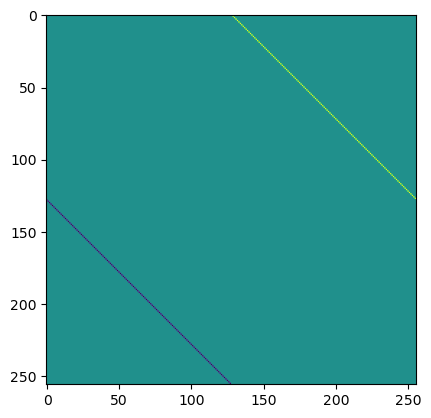

In [182]:
plt.imshow(gtn.C_m_history[0])

In [167]:
gtn.von_Neumann_entropy_m(np.arange(gtn.L))/np.log(2)

32.0

In [410]:
gtn2=GTN(L=4,seed=2,op=False)
# gtn2.measure([[0,np.sqrt(1/2),-np.sqrt(1/2)],[0,-0.1,np.sqrt(1-0.1**2)]],np.array([1,2,3,4]))
gtn2.measure_all_sync(0, 0, 1, 1,even=False)
gtn2.measure_all_sync(0, 0, 1, 1,even=True)

In [413]:
gtn.von_Neumann_entropy_m(range(gtn.L//2))

0.845082507932084

In [414]:
gtn2.von_Neumann_entropy_m(range(gtn.L//2))

0.8450825079320842

In [415]:
np.round(gtn.C_m_history[-1],2)

array([[ 0.  , -0.52, -0.19, -0.66, -0.2 , -0.11,  0.41,  0.2 ],
       [ 0.52,  0.  , -0.03,  0.33, -0.01, -0.64,  0.11,  0.45],
       [ 0.19,  0.03,  0.  ,  0.14, -0.85, -0.07,  0.05, -0.46],
       [ 0.66, -0.33, -0.14,  0.  ,  0.39,  0.18,  0.01, -0.51],
       [ 0.2 ,  0.01,  0.85, -0.39,  0.  , -0.14, -0.24, -0.04],
       [ 0.11,  0.64,  0.07, -0.18,  0.14,  0.  ,  0.7 , -0.16],
       [-0.41, -0.11, -0.05, -0.01,  0.24, -0.7 ,  0.  , -0.52],
       [-0.2 , -0.45,  0.46,  0.51,  0.04,  0.16,  0.52,  0.  ]])

In [416]:
np.round(gtn2.C_m_history[-1],2)

array([[ 0.  , -0.52,  0.19, -0.66,  0.2 , -0.11, -0.41,  0.2 ],
       [ 0.52,  0.  , -0.03, -0.33, -0.01,  0.64,  0.11, -0.45],
       [-0.19,  0.03,  0.  ,  0.14,  0.85, -0.07, -0.05, -0.46],
       [ 0.66,  0.33, -0.14,  0.  ,  0.39, -0.18,  0.01,  0.51],
       [-0.2 ,  0.01, -0.85, -0.39,  0.  , -0.14,  0.24, -0.04],
       [ 0.11, -0.64,  0.07,  0.18,  0.14,  0.  ,  0.7 ,  0.16],
       [ 0.41, -0.11,  0.05, -0.01, -0.24, -0.7 ,  0.  , -0.52],
       [-0.2 ,  0.45,  0.46, -0.51,  0.04, -0.16,  0.52,  0.  ]])

In [363]:
gtn.C_m_history[-1]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0., -0.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [-0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [165]:
gtn.measure([[0,1/np.sqrt(2),1/np.sqrt(2)]],np.array([0,1]))

In [275]:
gtn.measure([[0,1/np.sqrt(2),1/np.sqrt(2)]],np.array([3,0]))

In [364]:
# gtn.measure([[0.9,np.sqrt(1-0.9**2),0]],np.array([1,2]))
gtn.measure([[0,np.sqrt(1/2),np.sqrt(1/2)]]*3,np.array([1,2,3,4,5,0]))
# gtn.measure([[0.9,np.sqrt(1-0.9**2),0]],np.array([3,4]))

In [335]:
neg=np.round(gtn.C_m_history[-1],3)

In [338]:
pos=np.round(gtn.C_m_history[-1],3)

In [339]:
neg,pos

(array([[ 0. ,  0.5,  0.5,  0.5,  0.5,  0. ],
        [-0.5,  0. ,  0. ,  0.5, -0.5,  0.5],
        [-0.5,  0. ,  0. , -0.5,  0.5,  0.5],
        [-0.5, -0.5,  0.5,  0. ,  0. , -0.5],
        [-0.5,  0.5, -0.5,  0. ,  0. , -0.5],
        [ 0. , -0.5, -0.5,  0.5,  0.5,  0. ]]),
 array([[ 0. ,  0.5, -0.5,  0.5, -0.5,  0. ],
        [-0.5,  0. ,  0. , -0.5, -0.5, -0.5],
        [ 0.5,  0. ,  0. , -0.5, -0.5,  0.5],
        [-0.5,  0.5,  0.5,  0. ,  0. ,  0.5],
        [ 0.5,  0.5,  0.5,  0. ,  0. , -0.5],
        [ 0. ,  0.5, -0.5, -0.5,  0.5,  0. ]]))

In [251]:
gtn.C_m_history[-1]

array([[ 0.        ,  0.        ,  0.43588989,  0.9       ],
       [ 0.        ,  0.        ,  0.9       , -0.43588989],
       [-0.43588989, -0.9       ,  0.        ,  0.        ],
       [-0.9       ,  0.43588989,  0.        ,  0.        ]])

In [ ]:
gtn.C_m_history[-1]

array([[ 0.        , -0.1       , -0.99498744,  0.        ],
       [ 0.1       ,  0.        ,  0.        ,  0.99498744],
       [ 0.99498744,  0.        ,  0.        , -0.1       ],
       [ 0.        , -0.99498744,  0.1       ,  0.        ]])

In [72]:
gtn.measure_all_sync(a1=.5, a2=.9, b1=1, b2=1,even=True,theta_list=0,phi_list=0,Born=True)

In [77]:
np.round(gtn.C_m_history[-1],3)

array([[-0.   , -0.914,  0.   ,  0.   , -0.159,  0.372,  0.   ,  0.   ],
       [ 0.914, -0.   ,  0.   ,  0.   , -0.372, -0.159,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.   , -0.919,  0.   ,  0.   , -0.331, -0.215],
       [ 0.   ,  0.   ,  0.919, -0.   ,  0.   ,  0.   ,  0.215, -0.331],
       [ 0.159,  0.372,  0.   ,  0.   , -0.   ,  0.914,  0.   ,  0.   ],
       [-0.372,  0.159,  0.   ,  0.   , -0.914, -0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.331, -0.215,  0.   ,  0.   , -0.   ,  0.919],
       [ 0.   ,  0.   ,  0.215,  0.331,  0.   ,  0.   , -0.919, -0.   ]])

In [78]:
gtn.von_Neumann_entropy_m(np.arange(gtn.L))

0.3463744671333685

In [79]:
vk=gtn.n_history[0][:,0]

In [82]:
np.sum(-(1-vk)/2*np.log((1-vk)/2)-(1+vk)/2*np.log((1+vk)/2))

0.3463744671333685

In [563]:
gtn.measure_all_sync(a1=.5, a2=.9, b1=1, b2=1,even=True,theta_list=0,phi_list=0,Born=True)
gtn.measure_all_sync(a1=.5, a2=.9, b1=1, b2=1,even=False,theta_list=np.pi/2,phi_list=np.pi/2,Born=True)

In [ ]:
np.round(gtn.C_m_history[-1],3)

array([[ 0.   ,  0.238, -0.239, -0.364, -0.266,  0.166, -0.755,  0.293],
       [-0.238,  0.   , -0.762,  0.401, -0.016, -0.069, -0.126, -0.425],
       [ 0.239,  0.762,  0.   ,  0.488,  0.057, -0.112,  0.083,  0.317],
       [ 0.364, -0.401, -0.488,  0.   ,  0.269,  0.03 ,  0.175,  0.604],
       [ 0.266,  0.016, -0.057, -0.269,  0.   , -0.911, -0.095, -0.123],
       [-0.166,  0.069,  0.112, -0.03 ,  0.911,  0.   , -0.347, -0.068],
       [ 0.755,  0.126, -0.083, -0.175,  0.095,  0.347,  0.   , -0.498],
       [-0.293,  0.425, -0.317, -0.604,  0.123,  0.068,  0.498,  0.   ]])

In [550]:
gtn.measure([[1/np.sqrt(2),-1/np.sqrt(2),0]], [2,3])
gtn.measure([[1/np.sqrt(2),1/np.sqrt(2),0]], [0,1])

In [546]:
np.round(gtn.C_m_history[-1],3)

array([[ 0.   ,  0.873,  0.068,  0.104,  0.156, -0.076,  0.412, -0.15 ],
       [-0.873,  0.   ,  0.217, -0.114,  0.073,  0.031,  0.116,  0.397],
       [-0.068, -0.217,  0.   ,  0.944,  0.083, -0.093,  0.194,  0.057],
       [-0.104,  0.114, -0.944,  0.   ,  0.094,  0.026, -0.017,  0.273],
       [-0.156, -0.073, -0.083, -0.094,  0.   , -0.947, -0.066, -0.232],
       [ 0.076, -0.031,  0.093, -0.026,  0.947,  0.   , -0.295,  0.02 ],
       [-0.412, -0.116, -0.194,  0.017,  0.066,  0.295,  0.   , -0.829],
       [ 0.15 , -0.397, -0.057, -0.273,  0.232, -0.02 ,  0.829,  0.   ]])

In [551]:
np.round(gtn.C_m_history[-1],3)

array([[ 0.   ,  0.873,  0.068,  0.104,  0.156, -0.076,  0.412, -0.15 ],
       [-0.873,  0.   ,  0.217, -0.114,  0.073,  0.031,  0.116,  0.397],
       [-0.068, -0.217,  0.   ,  0.944,  0.083, -0.093,  0.194,  0.057],
       [-0.104,  0.114, -0.944,  0.   ,  0.094,  0.026, -0.017,  0.273],
       [-0.156, -0.073, -0.083, -0.094,  0.   , -0.947, -0.066, -0.232],
       [ 0.076, -0.031,  0.093, -0.026,  0.947,  0.   , -0.295,  0.02 ],
       [-0.412, -0.116, -0.194,  0.017,  0.066,  0.295,  0.   , -0.829],
       [ 0.15 , -0.397, -0.057, -0.273,  0.232, -0.02 ,  0.829,  0.   ]])

In [488]:
gtn.von_Neumann_entropy_m(np.arange(gtn.L)+gtn.L)

0.7680219731036124

In [241]:
i

63

In [475]:
np.round(rotate(np.array([[1,0,0]]*3), [0,np.pi/4,np.pi/2],[np.pi/2]*3),3)

array([[0.   , 0.   , 1.   ],
       [0.   , 0.707, 0.707],
       [0.   , 1.   , 0.   ]])

In [125]:
zz=np.arange(36).reshape((6,6))

In [85]:
zz

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [187]:
swap(zz,[1,2])

In [186]:
zz

array([[ 0,  4,  5,  3,  1,  2],
       [24, 28, 29, 27, 25, 26],
       [30, 34, 35, 33, 31, 32],
       [18, 22, 23, 21, 19, 20],
       [ 6, 10, 11,  9,  7,  8],
       [12, 16, 17, 15, 13, 14]])

In [188]:
zz

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [89]:
zz[np.ix_([1,2],[1,2])]

array([[ 7,  8],
       [13, 14]])

In [119]:
# zz=get_Born(b2=.3,a2=.2, a1=.5,b1= 1,Gamma=np.linspace(-1,1,1000))
z0=get_random_tri_op(.5, 10000)
# z0=get_Born_tri_op(.5,10000,Gamma=np.array([.5]*10000))
# z0=get_random(a1=0.5, b1=.6, b2=1, a2=.5,rng=0,num=2000,theta_list=0,phi_list=0)
# z1=get_random(b2=.3,a2=.2, a1=.5,b1= 1,rng=0,num=1,theta_list=np.pi/2,phi_list=np.pi/2)

(array([2551.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 4885.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 2564.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

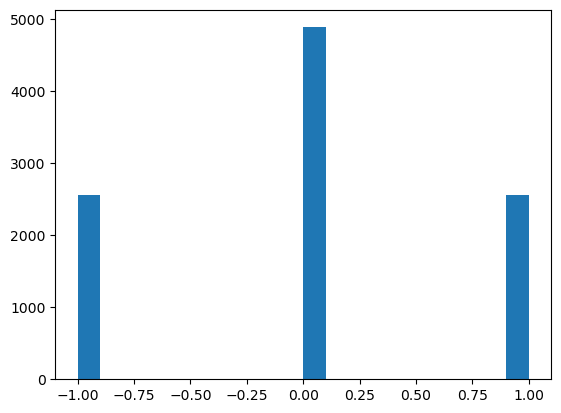

In [120]:
plt.hist(z0[:,0],density=False,bins=20)

(array([0.76151494, 0.47901746, 0.44626413, 0.43398163, 0.44012288,
        0.48106454, 0.49948829, 0.47492329, 0.51995912, 0.50153537,
        0.49744121, 0.51177079, 0.47697038, 0.46264079, 0.46468788,
        0.48925288, 0.41965205, 0.49129996, 0.39303997, 0.75537369]),
 array([-9.99999754e-01, -8.99999766e-01, -7.99999778e-01, -6.99999791e-01,
        -5.99999803e-01, -4.99999815e-01, -3.99999828e-01, -2.99999840e-01,
        -1.99999852e-01, -9.99998648e-02,  1.22878912e-07,  1.00000111e-01,
         2.00000098e-01,  3.00000086e-01,  4.00000073e-01,  5.00000061e-01,
         6.00000049e-01,  7.00000036e-01,  8.00000024e-01,  9.00000012e-01,
         9.99999999e-01]),
 <BarContainer object of 20 artists>)

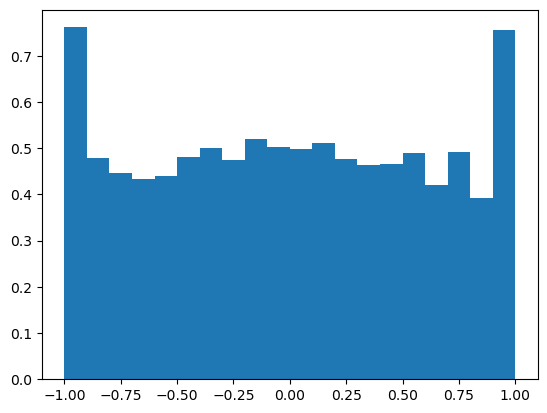

In [122]:
plt.hist(z0[np.abs(z0[:,0])<1,2],density=True,bins=20)

In [27]:
zz=get_Born(a1=0.7, b1=1, b2=1, a2=0, Gamma=np.array([-1]*1000000))

NameError: name 'get_Born' is not defined

In [380]:
# zz=np.vstack([get_Born_A(a1=0.7, b1=.9, b2=.9, a2=0.7,Gamma=np.array([1,])) for i in range(10000)])
# zz=[get_random_phi(0.1, 1, np.random.uniform()) for i in range(1000)]

In [85]:
zz=np.vstack([get_Born_B(a1=0.5, b1=1, b2=1, a2=.4,Gamma=np.array([1,])) for i in range(50000)])
# zz=np.vstack([get_Born_A(a1=0.5, b1=1, b2=1, a2=.4,Gamma=np.array([1,])) for i in range(50000)])

(-1.0, 1.0)

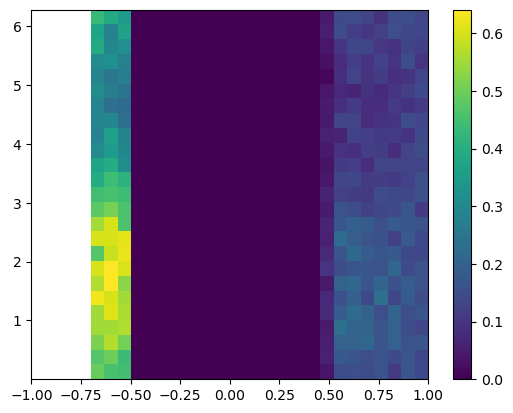

In [38]:
plt.hist2d(*zz.T,density=True,bins=(25, 25))
plt.colorbar()
plt.xlim(-1,1)

In [50]:
def p(s,phi,a1,a2,b1,b2,Gamma):
    omega=((a1+b1)/((b2-a2)*(a1+a2+b1+b2)))*(s<=b2)*(s>=a2)+((a2+b2)/((b1-a1)*(a1+a2+b1+b2)))*(s>=-b1)*(s<=-a1)
    # return omega
    return omega*(1+np.sqrt(1-s**2)*np.sin(phi)*Gamma)/(2*np.pi)


In [84]:
s_list=np.linspace(-1,1,1001)
phi_list=np.linspace(0,2*np.pi,1001)
S_list,Phi_list=np.meshgrid(s_list,phi_list)
pdf=p(S_list,Phi_list,a1=0.5, b1=.7, b2=1, a2=.5,Gamma=.5)

/tmp/ipykernel_24812/1417036197.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(s_list,phi_list,pdf)


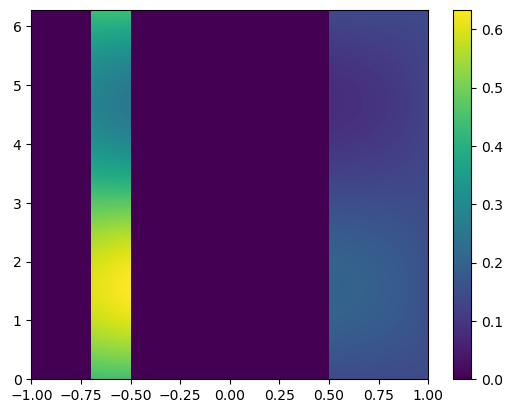

In [85]:
plt.pcolormesh(s_list,phi_list,pdf)
plt.colorbar()

In [79]:
s_list[0]-s_list[1]

-0.020000000000000018

In [82]:
2/100

0.02

In [86]:
pdf.sum()*4*np.pi/(1000*1000)

1.008340666666667

array([0.        , 0.        , 0.        , ..., 0.88977778, 0.88977778,
       0.88977778])

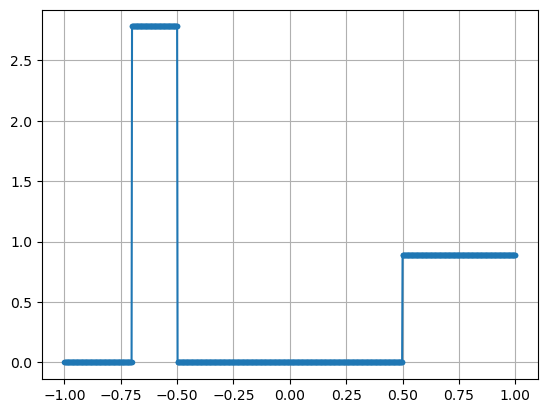

In [89]:
plt.plot(s_list,pdf.sum(axis=0)*2*np.pi/(1000),'.-')
plt.grid('on')

In [370]:
def f(s,Gamma,phi):
    return (1+np.sqrt(1-s**2)*Gamma*np.sin(phi))/(2*np.pi)

In [372]:
x=np.linspace(0,2*np.pi)

(-1.0, 1.0)

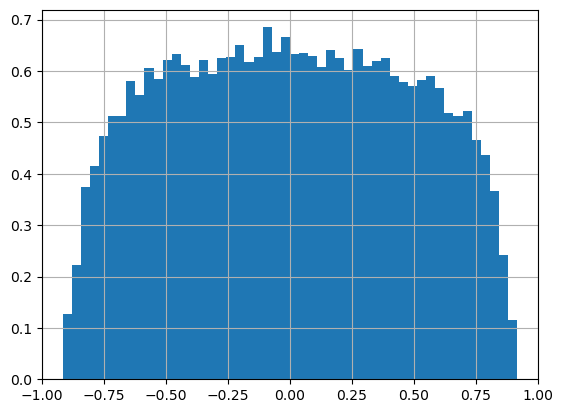

In [88]:
fig,ax=plt.subplots()
# ax.hist(zz,bins=30,density=True)
# ax.plot(x,f(0.1,1,x))
# ax.hist(zz[zz[:,1]<0,0],bins=30,density=True)
# ax.hist(zz[zz[:,1]>0,0],bins=30,density=True)
ax.hist(zz[:,2],bins=50,density=True)
# ax.hist(np.sqrt(1-zz[:,0]**2)*np.sin(zz[:,1]),bins=30,density=True)
# ax.hist(np.sqrt(1-zz[:,0]**2)*np.cos(zz[:,1]),bins=30,density=True)

# ax.hist(np.sqrt(zz[:,0]**2+zz[:,2]**2),bins=30,density=True)
ax.grid('on')
ax.set_xlim([-1,1])
# ax.set_ylim([0,1])

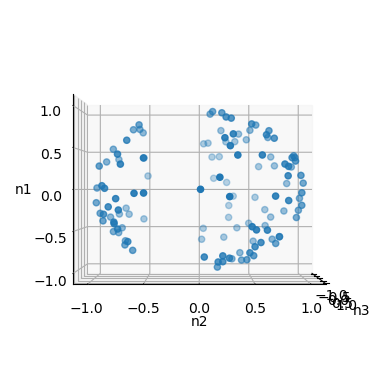

In [126]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# zz=np.array(gtn.n_history[:32])
ax.scatter(zz[:,2],zz[:,1],zz[:,0])
ax.set_xlabel('n3')
ax.set_ylabel('n2')
ax.set_zlabel('n1')
ax.view_init(azim=0,elev=0)

In [321]:
gtn=GTN(L=2,seed=2)
gtn.measure([[1,0,0],[1,0,0]], [1,2,3,0])
np.round(gtn.C_m_history[-1],3)

array([[ 0.,  0.,  0., -1.],
       [ 0.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]])

In [347]:
gtn_orig=GTN(L=3,seed=2)
# gtn_orig.measure([[1,0,0]], [1,2])
# gtn_orig.measure([[1,0,0]], [3,4])
gtn_orig.measure([[1,0,0]], [5,0])
# gtn_orig.measure([[1,0,0]], [3,0])
np.round(gtn_orig.C_m_history[-1],3)

array([[ 0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
gtn_orig=GTN(L=4,seed=2)
gtn_orig.measure([[1,0,0]], [3,4])
gtn_orig.measure([[1,0,0]], [1,2])
np.round(gtn_orig.C_m_history[-1],3)

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [284]:
np.array_equal(gtn_orig.C_m_history[-1], gtn.C_m_history[-1])

True

In [184]:
gtn_orig_2=GTN(L=2,seed=2)
gtn_orig_2.measure([[1,0,0]], [3,4])
gtn_orig_2.measure([[1,0,0]], [1,2])
np.round(gtn_orig_2.C_m_history[-1],3)

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [185]:
gtn_orig_2.C_m_history[-1]==gtn_orig.C_m_history[-1]

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [176]:
np.round(gtn.C_m_history[-1],3)

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [482]:
gtn=GTN(L=4,seed=2)

In [480]:
gtn.measure_all(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
gtn.measure_all(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

In [483]:
gtn.measure_all_sync(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
gtn.measure_all_sync(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

In [484]:
gtn.mutual_information_cross_ratio()

0.2993099195910174

In [481]:
gtn.mutual_information_cross_ratio()

0.2993099195910174

In [ ]:
gtn.mutual_information_cross_ratio()

0.4530013255727704

In [ ]:
gtn.n_history

In [ ]:
gtn.n_history

In [429]:
L=512

In [443]:
def profile():
    gtn=GTN(L=L,seed=1,history=False)
    iteration=range(1)
    for i in iteration:
        gtn.measure_all(b2=1,a2= .9999, a1=.9999,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
        gtn.measure_all(b2=1,a2= .9999, a1=.9999,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

In [441]:
profile()

In [ ]:
%lprun -f _contraction profile()

In [489]:
L=64
iteration=np.arange(100)
MI=np.zeros((iteration.shape[0],))
gtn=GTN(L=L,seed=0)
for i in iteration:
    gtn.measure_all_sync(b2=1,a2= .999, a1=.999,b1= 1,even=True,theta_list=0,phi_list=0)
    gtn.measure_all_sync(b2=1,a2= .999, a1=.999,b1= 1,even=False,theta_list=np.pi/2,phi_list=np.pi/2)
    # MI[i]=(gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2)))
    MI[i]=gtn.mutual_information_cross_ratio()

In [519]:
L=64
iteration=np.arange(100)
MI=np.zeros((iteration.shape[0],))
gtn=GTN(L=L,seed=0)
for i in iteration:
    gtn.measure_all_sync(b2=1,a2= .999, a1=.999,b1= 1,even=True,theta_list=0,phi_list=0)
    gtn.measure_all_sync(b2=1,a2= .999, a1=.999,b1= 1,even=False,theta_list=np.pi/2,phi_list=0)
    # MI[i]=(gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2)))
    MI[i]=gtn.mutual_information_cross_ratio()

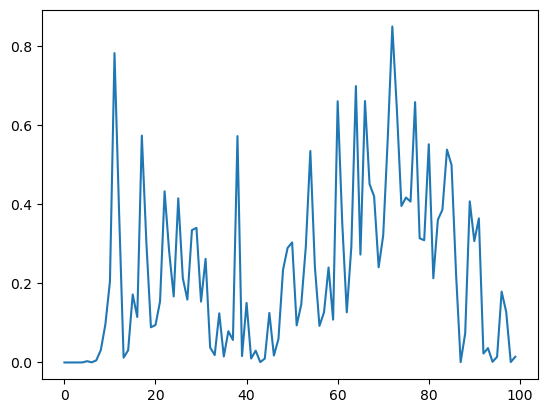

In [520]:
plt.plot(iteration,MI/np.log(2))

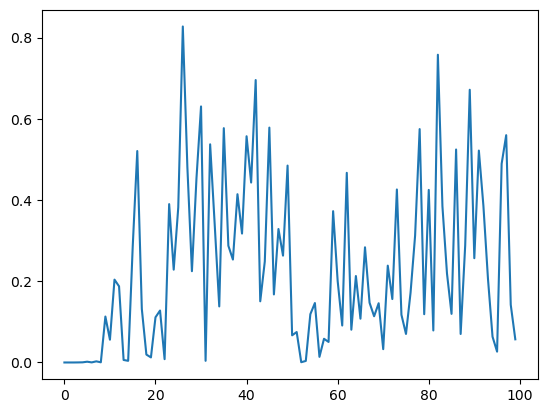

In [351]:
plt.plot(iteration,MI/np.log(2))

In [153]:
gtn=GTN(L=4,seed=1)
gtn.measure_all_sync(b2=1,a2=.999, a1=.999,b1= 1,Born=True,even=True,theta_list=np.pi/2,phi_list=0)

In [154]:
gtn.C_m_history[-1]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [56]:
gtn.C_m_history[-1]

array([[ 0.        ,  0.8793489 , -0.31069002, ..., -0.0505494 ,
         0.25427033,  0.24345584],
       [-0.8793489 ,  0.        , -0.03841756, ..., -0.04010213,
         0.22079822, -0.24877816],
       [ 0.31069002,  0.03841756,  0.        , ...,  0.01488309,
        -0.0755048 ,  0.08707611],
       ...,
       [ 0.0505494 ,  0.04010213, -0.01488309, ...,  0.        ,
        -0.19456474, -0.15580733],
       [-0.25427033, -0.22079822,  0.0755048 , ...,  0.19456474,
         0.        ,  0.90185994],
       [-0.24345584,  0.24877816, -0.08707611, ...,  0.15580733,
        -0.90185994,  0.        ]])

In [598]:
phi=np.pi/2

In [600]:
isinstance(phi,float)

True

In [57]:
iteration.shape

(64,)

## Tri-operators

In [36]:
L=64
gtn=GTN(L=L,seed=0,history=True,op=False,random_init=False,trijunction=True)

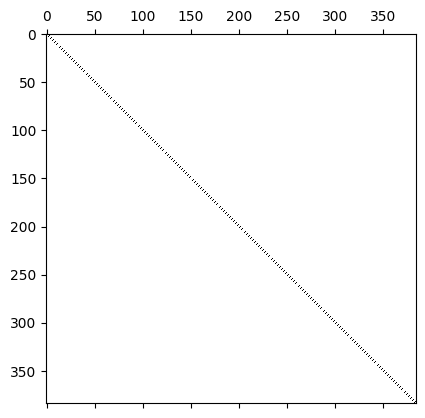

In [37]:
plt.spy(gtn.C_m)

In [93]:

# p=0.
# odd=interpolation(gtn.L//4,gtn.L//4*3,p,1-p,gtn.L,k=1)
# even=interpolation(gtn.L//4,gtn.L//4*3,1-p,p,gtn.L,k=1)

# odd=interpolation(gtn.L//4,gtn.L//4*3,1-p,1-p,gtn.L,k=1)
# even=interpolation(gtn.L//4,gtn.L//4*3,p,p,gtn.L,k=1)


odd=np.r_[interpolation(gtn.L//8,gtn.L//8*3,p,1-p,gtn.L//2,k=2) , interpolation(gtn.L//8,gtn.L//8*3,p,1-p,gtn.L//2,k=2)]
even=np.r_[interpolation(gtn.L//8,gtn.L//8*3,1-p,p,gtn.L//2,k=2),interpolation(gtn.L//8,gtn.L//8*3,1-p,p,gtn.L//2,k=2)]

(0.0, 64.0)

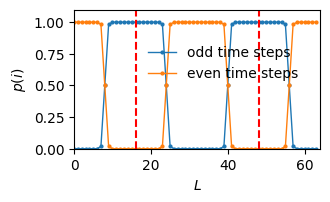

In [94]:
fig,ax=plt.subplots(figsize=(3.4,3.4/1.6),tight_layout=True)
ax.plot(odd,'.-',label='odd time steps',lw=1,markersize=4)
ax.plot(even,'.-',label='even time steps',lw=1,markersize=4)
ax.legend(loc=(.28,.45),frameon=False)
ax.set_xlabel('$L$')
ax.set_ylabel('$p(i)$')
ax.axvline(x=gtn.L//4,ls='dashed',color='r')
ax.axvline(x=gtn.L//4*3,ls='dashed',color='r')
ax.set_ylim([0,1.1])
ax.set_xlim([0,gtn.L])
# fig.savefig('../Rp_GTN/Fig/p_i.pdf')

In [195]:
[[1,2],[2,3]]*2

[[1, 2], [2, 3], [1, 2], [2, 3]]

In [95]:
L=64
# iteration=np.arange(L//2)
iteration=np.arange(16)
ensemble_size=1
MI=np.zeros((ensemble_size,iteration.shape[0],))
EC=np.zeros((ensemble_size,2*iteration.shape[0]+1,2*L))
EE=np.zeros((ensemble_size,iteration.shape[0],L//2-1))
# gtn_list=[]
# sigma=0.6
SL2=np.zeros((ensemble_size,iteration.shape[0]))
# p=0.1
v=0
for ensemble in range(ensemble_size):
    gtn=GTN(L=L,seed=None,history=True,op=False,random_init=False,pbc=False)
    # EC[ensemble,0]=gtn.entanglement_contour(L+np.arange(gtn.L))
    for i in (iteration):

        # gtn.measure_all_tri_op(p_list=p,Born=True,even=True) 
        # gtn.measure_all_tri_op(p_list=1-p,Born=True,even=False)
        # p_list_even=interpolation(gtn.L//4+(v*(2*i+2)),gtn.L//4*3+(v*(2*i+2)),p,1-p,gtn.L,k=2)
        gtn.measure_all_tri_op(p_list=even,Born=True,even=True)
        # print(f'{i} Even:\n {gtn.C_m_history[-1]}')
        # interpolation(gtn.L//4+(v*(2*i+1)),(gtn.L//4*3+(v*(2*i+1))),p,1-p,gtn.L,k=2)
        # EC[ensemble,2*i+1]=gtn.entanglement_contour(gtn.L+np.arange(gtn.L))

        # p_list_odd=interpolation(gtn.L//4+(v*(2*i+2)),gtn.L//4*3+(v*(2*i+2)),1-p,p,gtn.L,k=2)
        gtn.measure_all_tri_op(p_list=odd,Born=True,even=False)
        # print(f'{i} Odd:\n {gtn.C_m_history[-1]}')
        # interpolation(gtn.L//4+(v*(2*i+2)),gtn.L//4*3+(v*(2*i+2)),1-p,p,gtn.L,k=2)

        # gtn.measure_all_tri_op(p_list=p,Born=False,even=True) 
        # gtn.measure_all_tri_op(p_list=1-p,Born=False,even=False)

        # gtn.measure_all_sync(b2=1,a2=.9, a1=.5,b1= 1,Born=True,even=True,theta_list=interpolate(gtn.L//4, gtn.L//4*3, 0, np.pi/2, gtn.L,k=1),phi_list=0)
        # gtn.measure_all_sync(b2=1,a2=.9, a1=.5,b1= 1,Born=True,even=False,theta_list=interpolate(gtn.L//4, gtn.L//4*3, np.pi/2, 0, gtn.L,k=1),phi_list=0)

        # gtn.measure_all_sync(b2=1,a2=0., a1=.5,b1= 1,Born=True,even=True)
        # gtn.measure_all_sync(b2=1,a2=0., a1=.5,b1= 1,Born=True,even=False)

        # gtn.measure_all_sync(b2=0.1,a2=.0, a1=.5,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
        # gtn.measure_all_sync(b2=0.1,a2=.0, a1=.5,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

        # gtn.measure_all_sync(b2=1,a2=0.999, a1=0.999,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
        # gtn.measure_all_sync(b2=1,a2=0.999, a1=0.999,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=0)

        # gtn.measure_all_Haar(sigma=sigma,even=True,theta_list=0,phi_list=0)
        # gtn.measure_all_Haar(sigma=sigma,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

        # MI[ensemble,i]=(gtn.mutual_information_m((gtn.L//8*7+np.arange(gtn.L//4))%gtn.L, (gtn.L//8*3+np.arange(gtn.L//4))))
        # MI[ensemble,i]=(gtn.mutual_information_m(gtn.L//8+np.arange(gtn.L//4), gtn.L//8*5+np.arange(gtn.L//4)))

        # MI[ensemble,i]=gtn.mutual_information_m(gtn.L//8+np.arange(gtn.L//4*3), gtn.L+gtn.L//8+np.arange(gtn.L//4*3))

        # EC[ensemble,2*i+2]=gtn.entanglement_contour(gtn.L+np.arange(gtn.L))
        # EC[ensemble,i]=np.r_[gtn.entanglement_contour(np.arange(gtn.L//2)),gtn.entanglement_contour(gtn.L//2+np.arange(gtn.L//2))]
        # EE[ensemble,i,:]=[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L)/np.log(2) for i in range(gtn.L)]) for dl in range(gtn.L//2-1,gtn.L//2)]
        # if i>=gtn.L:
        #     MI[ensemble, i-gtn.L]=gtn.mutual_information_cross_ratio()
        # MI[ensemble, i]=gtn.mutual_information_cross_ratio(ratio=[1,4])
        # SL2[ensemble,i]=gtn.von_Neumann_entropy_m(np.arange(gtn.L))
    # SL2[ensemble,i]=np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+gtn.L//2))%gtn.L) for i in range(gtn.L)])

mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular


mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular
mat2 is singular


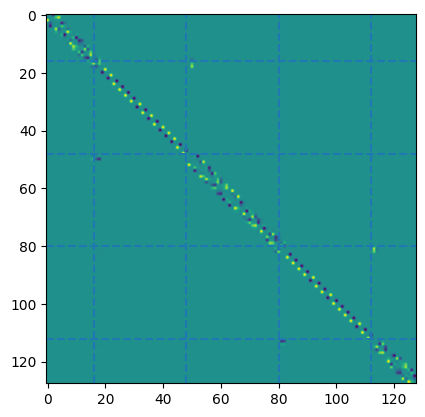

In [97]:
plt.imshow(gtn.C_m_history[-1],cmap='seismic')
for bdy in [gtn.L//8,gtn.L//8*3,gtn.L//8*5,gtn.L//8*7]:
    plt.axvline(x=bdy*2,ls='dashed')
    plt.axhline(y=bdy*2,ls='dashed')

In [89]:
gtn.mutual_information_m(np.arange(gtn.L//2), np.arange(gtn.L//2,gtn.L))/np.log(2)

2.00000000000005

In [90]:
gtn.mutual_information_m(np.arange(gtn.L//4), np.arange(gtn.L//4,gtn.L))/np.log(2)

1.0106432863800476

In [98]:
MI=[gtn.mutual_information_m(np.arange(x), np.arange(x,gtn.L))/np.log(2) for x in range(1,gtn.L-1)]

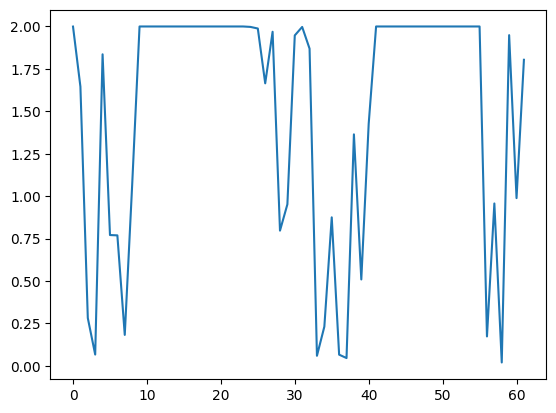

In [99]:
plt.plot(MI)

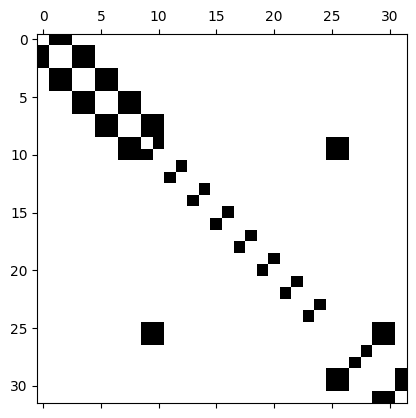

In [33]:
plt.spy(gtn.C_m_history[-1])

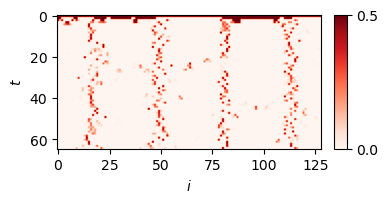

In [143]:
fig,ax=plt.subplots(figsize=(3.4,3.4/1.6))
im=ax.imshow(EC.mean(axis=0)/np.log(2),cmap='Reds')
axins=ax.inset_axes([1.05, 0, 0.05, 1],transform=ax.transAxes)
# ax.imshow(np.array([ec/nla.norm(ec) for ec in EC[0]]),cmap='Reds')
ax.set_ylabel('$t$')
ax.set_xlabel('$i$')
# ax.set_ylim([20,0])
plt.colorbar(im,cax=axins,ticks=[0,.5])
# fig.savefig('EC_p_0.8_k_2.pdf')

In [212]:
gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2))/np.log(2)

1.0414638538766658

In [213]:
gtn.mutual_information_m(np.arange(gtn.L//8), np.arange(gtn.L//8,gtn.L))/np.log(2)

2.0000000000004325

In [214]:
gtn.mutual_information_m(np.arange(gtn.L//4), np.arange(gtn.L//4,gtn.L//2))/np.log(2)

2.0000000000001625

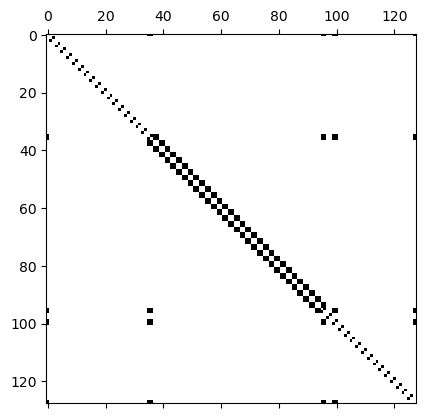

In [215]:
plt.spy(gtn.C_m_history[-1])

In [ ]:
?? Why open chain not show correct entanglement?

In [30]:
gtn.mutual_information_m(np.arange(gtn.L), np.arange(gtn.L)+gtn.L)/np.log(2)

3.966932252807668

(0.0, 1.0)

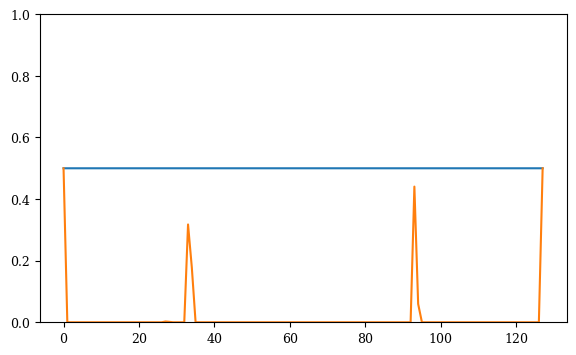

In [118]:
fig,ax=plt.subplots()
ax.plot(EC[0,0]/np.log(2))
# ax.plot(EC[0,1]/np.log(2))
ax.plot(EC[0,20]/np.log(2))
ax.set_ylim([0,1])

(0.0, 1.0)

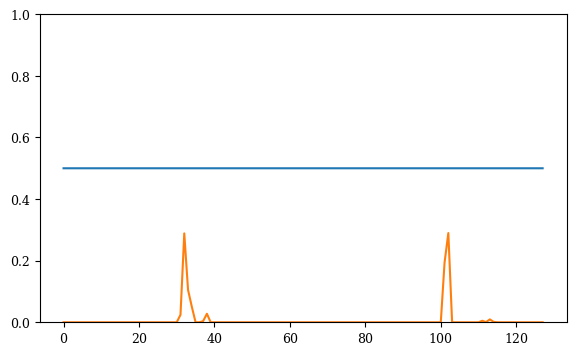

In [109]:
fig,ax=plt.subplots()
ax.plot(EC[0,0]/np.log(2))
# ax.plot(EC[0,1]/np.log(2))
ax.plot(EC[0,20]/np.log(2))
ax.set_ylim([0,1])

In [53]:
EC[0,0].sum()/np.log(2)

63.99999999999999

In [103]:
EC[0,-1].sum()/np.log(2)

0.999999999146669

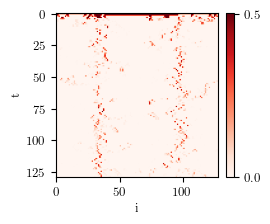

In [ ]:
fig,ax=plt.subplots(figsize=(3.4,3.4/1.6))
im=ax.imshow(EC.mean(axis=0)/np.log(2),cmap='Reds')
axins=ax.inset_axes([1.05, 0, 0.05, 1],transform=ax.transAxes)
# ax.imshow(np.array([ec/nla.norm(ec) for ec in EC[0]]),cmap='Reds')
ax.set_ylabel('t')
ax.set_xlabel('i')
plt.colorbar(im,cax=axins,ticks=[0,.5])
# fig.savefig('EC_p_0.8_k_2.pdf')

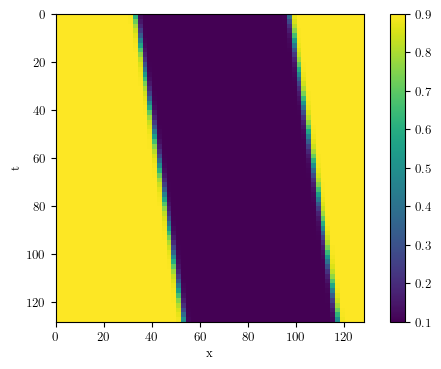

In [ ]:
plt.imshow(np.vstack(gtn.p_history[::2]),extent=[0,128,128,0])
plt.ylabel('t')
plt.xlabel('x')
plt.colorbar()

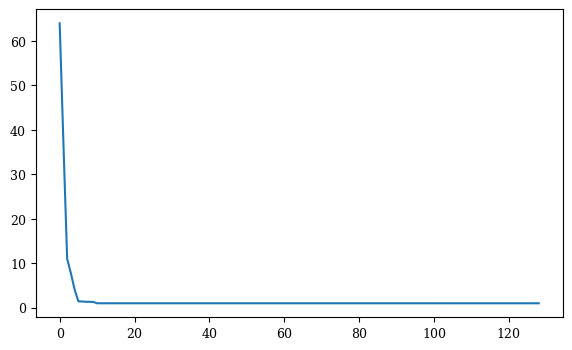

In [58]:
plt.plot(EC[0].sum(axis=-1)/np.log(2))

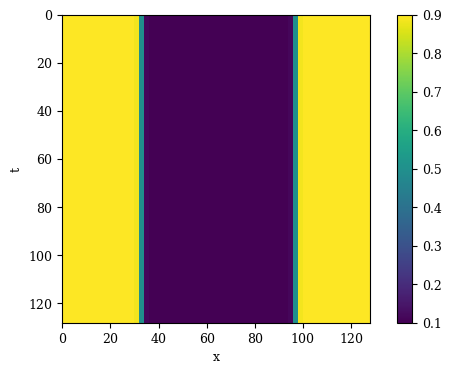

In [39]:
plt.imshow(np.vstack(gtn.p_history[::2]),extent=[0,128,128,0])
plt.ylabel('t')
plt.xlabel('x')
plt.colorbar()

## Braid

In [146]:
def initialization(L,p,time=5,site_lists=None,p_lists=None):
    if site_lists is None or p_lists is None:
        site_lists=[]
        p_lists=[]
    else:
        assert isinstance(site_lists, list) and isinstance(p_lists, list), f'site_lists type:{type(site_lists)} and p_lists type:{type(p_lists)}should be list'

    i_list=np.arange(0,2*L,2)
    # j_list=i_list+1
    site_0_list=[[leg*2*L+i,leg*2*L+i+1] for leg in range(3) for i in i_list ]
    site_1_list=[[leg*2*L+i+1,leg*2*L+i+2] for leg in range(3) for i in i_list[:-1]] 
    start_pos=L*1//4
    end_pos=L*3//4
    p_lhl=list(interpolation(x1=start_pos,x2=end_pos,l0=p,h0=1-p,L=L))
    p_hlh=list(interpolation(x1=start_pos,x2=end_pos,l0=1-p,h0=p,L=L-1))
    p_l=list(interpolation(x1=start_pos,x2=end_pos,l0=p,h0=p,L=L))
    p_h=list(interpolation(x1=start_pos,x2=end_pos,l0=1-p,h0=1-p,L=L-1))
    p_0_list=p_lhl+p_lhl+p_l
    p_1_list=p_hlh+p_hlh+p_h
    for t in range(time):
        site_lists.append(site_0_list)
        p_lists.append(p_0_list)
        site_lists.append(site_1_list)
        p_lists.append(p_1_list)
    
    return site_lists,p_lists

 

In [ ]:
np.arange

In [150]:
z=np.linspace([0,10],[1,12],11)

In [157]:
def shift_DW(L,p,leg,start,end,time=10,site_lists=None,p_lists=None):
    '''
    time: total time step of shifting of domain wall from `start` to `end`
    start: [start_0, start_1] starting profile of prob at even sites, and odd sites
    end: [end_0, end_1] end profile of prob at even sites, and odd sites

    The evolution trajectory is the interpolation between the start and end.
    '''
    if site_lists is None or p_lists is None:
        site_lists=[]
        p_lists=[]
    else:
        assert isinstance(site_lists, list) and isinstance(p_lists, list), f'site_lists type:{type(site_lists)} and p_lists type:{type(p_lists)}should be list'
    assert leg ==0 and leg ==1 and leg ==2, f'chain number {leg} should be 0,1,2 '
    site_0_list=[[leg*2*L+i,leg*2*L+i+1] for i in i_list ]
    site_1_list=[[leg*2*L+i+1,leg*2*L+i+2] for i in i_list[:-1]]

    start_0,start_1=start
    end_0, end_1=end
    evo_0=np.linspace(start_0,end_0,time)
    evo_1=np.linspace(start_1,end_1,time)
    for evo_e,evo_o in zip(evo_0.tolist(),evo_1.tolist()):
        site_lists.append(even_site)
        p_lists.append(evo_e)
        site_lists.append(odd_site)
        p_lists.append(evo_o)

    return site_lists,p_lists
        




In [463]:
class Braiding:
    def __init__(self,L,p,left_pos=None,right_pos=None):
        self.L=L
        self.p=p
        self.site_lists=[]
        self.p_lists=[]
        self.left_pos=L//4 if left_pos is None else left_pos
        self.right_pos=3*L//4 if right_pos is None else right_pos
        self.initialize_index()
        

    
    def initialize_index(self):
        i_list=np.arange(0,2*self.L,2)

        self.site_0_list=[[[leg*2*self.L+i,leg*2*self.L+i+1]  for i in i_list] for leg in range(3)]
        self.site_1_list=[[[leg*2*self.L+i+1,leg*2*self.L+i+2] for i in i_list[:-1]] for leg in range(3)]
        self.p_lhl=list(interpolation(x1=self.left_pos,x2=self.right_pos,l0=self.p,h0=1-self.p,L=self.L))
        self.p_hlh=list(interpolation(x1=self.left_pos,x2=self.right_pos,l0=1-self.p,h0=self.p,L=self.L-1))
        self.p_l=[self.p]*self.L
        self.p_h=[1-self.p]*(self.L-1)
        self.outer={leg:(leg)*2*self.L for leg in range(3)}
        self.inner={leg:(1+leg)*2*self.L-1 for leg in range(3)}



    def initialization(self,time=5):
        p_0_list=self.p_lhl+self.p_lhl+self.p_l
        p_1_list=self.p_hlh+self.p_hlh+self.p_h
        site_0_list_all=sum(self.site_0_list,[])
        site_1_list_all=sum(self.site_1_list,[])
        site_list=[site_0_list_all,site_1_list_all]*time
        p_list=[p_0_list,p_1_list]*time
        return site_list,p_list
        
    def shift_DW(self,leg,start,end,time=10):
        '''
        time: total time step of shifting of domain wall from `start` to `end`
        leg: which leg is operate
        start: [left, right] the position of left and right domain wall in the starting stage
        end: [left, left] the position of left and right domain wall in the final stage
        The evolution trajectory is the interpolation between the start and end.
        '''
        assert leg in range(3), f'leg number {leg} should be 0,1,2'
        

        # start_left_pos,start_right_pos=start, start
        # end_left_pos, end_right_pos=end,end
        intermediate_pos=np.linspace(start,end,time).tolist()
        # intermediate_1_pos=np.linspace(start,end,time).tolist()
        p_list=[]
        for  intermediate in intermediate_pos:
            p_list.append(interpolation(x1=intermediate[0],x2=intermediate[1],l0=self.p,h0=1-self.p,L=self.L))
            p_list.append(interpolation(x1=intermediate[0],x2=intermediate[1],l0=1-self.p,h0=self.p,L=self.L-1))

        site_list=[self.site_0_list[leg],self.site_1_list[leg]]*time

        return site_list,p_list


    def link(self,left,right,time=4):
        
        site_list=[[[self.inner[left],self.inner[right]]]]*time
        p_list=[[self.p]]*time
        return site_list,p_list
        

    def pipeline(self,steps):
        for step,kwargs in steps:
            site_list,p_list=step(**kwargs)
            self.site_lists+=site_list
            self.p_lists+=p_list



        


In [464]:
braiding=Braiding(L=gtn.L, p=1)

In [465]:
braiding.pipeline(
    [
    (braiding.initialization,dict(time=5)),
    (braiding.shift_DW,dict(leg=0, start=[braiding.left_pos,braiding.right_pos], end=[braiding.left_pos,braiding.L+1])),
    (braiding.link,dict(left=0,right=2,)),
    (braiding.shift_DW,dict(leg=2, start=[braiding.L+1,braiding.L+2], end=[braiding.right_pos,braiding.L+2]))
    ])

(0.0, 384.0)

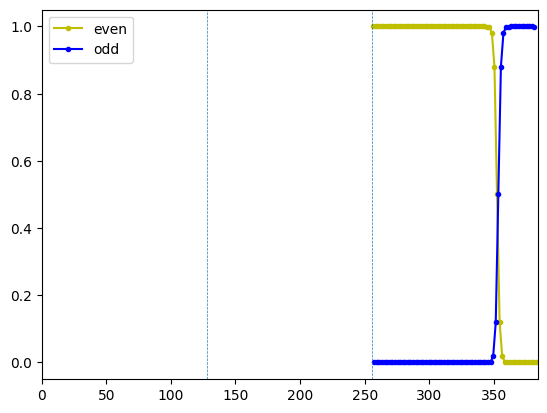

In [478]:
idx=26
fig,ax=plt.subplots()
ax.plot(np.array(braiding.site_lists[2*idx]).mean(axis=1),braiding.p_lists[2*idx],'.-',label='even',color='y')
ax.plot(np.array(braiding.site_lists[2*idx+1]).mean(axis=1),braiding.p_lists[2*idx+1],'.-',label='odd',color='b')
ax.axvline(x=braiding.L*2,ls='dashed',lw=0.5)
ax.axvline(x=braiding.L*4,ls='dashed',lw=0.5)
ax.legend()
ax.set_xlim([0,braiding.L*6])

In [417]:
braiding.site_lists[-1]

[[127, 383]]

In [400]:
braiding.site_lists[-1]

[[127, 255]]

In [407]:
braiding.p_lists[-1]

[1]

In [475]:
L=64
# iteration=np.arange(L)
iteration=np.arange(12)
MI=np.zeros((iteration.shape[0],))
EC=np.zeros((2*iteration.shape[0]+1,2*L))
EE=np.zeros((iteration.shape[0],L//2-1))
# SL2=np.zeros((ensemble_size,iteration.shape[0]))
# p=.1
# v=0
gtn=GTN(L=L,seed=None,history=True,op=False,trijunction=True,random_init=False)
# EC[ensemble,0]=gtn.entanglement_contour(L+np.arange(gtn.L))

# for site_list,p_list in tqdm(zip(site_lists,p_lists)):
for site_list,p_list in tqdm(zip(braiding.site_lists,braiding.p_lists)):
    gtn.measure_list_tri_op(site_list, p_list)

54it [01:47,  2.00s/it]


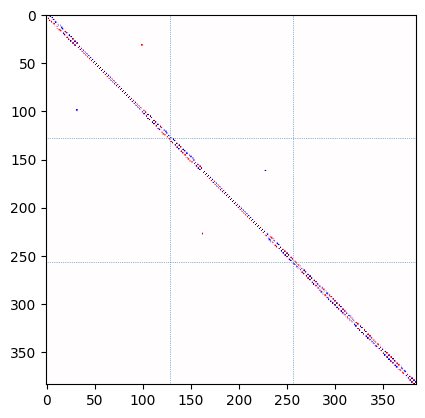

In [252]:
plt.imshow(gtn.C_m_history[-1],cmap='seismic')
for bdy in [gtn.L,gtn.L*2,]:
    plt.axvline(x=bdy*2,ls='dotted',lw=0.5)
    plt.axhline(y=bdy*2,ls='dotted',lw=0.5)

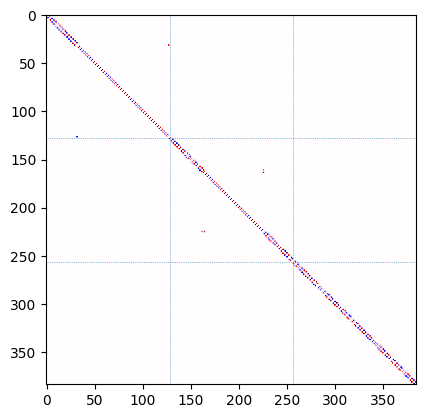

In [364]:
plt.imshow(gtn.C_m_history[-1],cmap='seismic')
for bdy in [gtn.L,gtn.L*2,]:
    plt.axvline(x=bdy*2,ls='dotted',lw=0.5)
    plt.axhline(y=bdy*2,ls='dotted',lw=0.5)

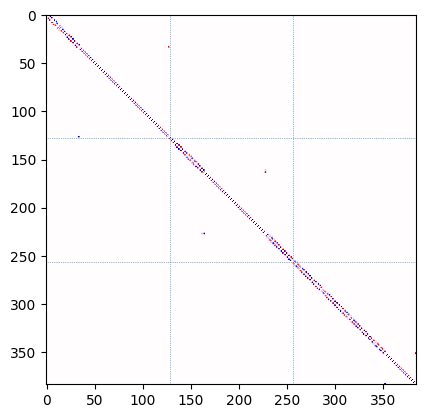

In [476]:
plt.imshow(gtn.C_m_history[-1],cmap='seismic')
for bdy in [gtn.L,gtn.L*2,]:
    plt.axvline(x=bdy*2,ls='dotted',lw=0.5)
    plt.axhline(y=bdy*2,ls='dotted',lw=0.5)

In [253]:
gtn.mutual_information_m(np.arange(gtn.L//2), np.arange(gtn.L//2,gtn.L))/np.log(2)

1.9999999999997646

In [254]:
gtn.mutual_information_m(np.arange(gtn.L), np.arange(gtn.L,2*gtn.L))/np.log(2)

1.7209061752051899e-13

In [255]:
gtn.mutual_information_m(gtn.L+np.arange(gtn.L//2), gtn.L+np.arange(gtn.L//2,gtn.L))/np.log(2)

2.000000000000051

In [256]:
gtn.mutual_information_m(2*gtn.L+np.arange(gtn.L//2), 2*gtn.L+np.arange(gtn.L//2,gtn.L))/np.log(2)

0.013808613202513934

In [180]:
gtn.C_m_history[-1][40:44,40:44]

array([[ 0.        ,  0.25201435,  0.63565359,  0.        ],
       [-0.25201435,  0.        ,  0.        , -0.47194181],
       [-0.63565359,  0.        ,  0.        ,  0.18710838],
       [ 0.        ,  0.47194181, -0.18710838,  0.        ]])

(50.0, 30.0)

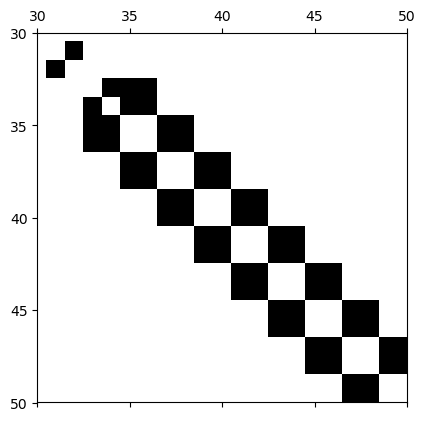

In [179]:
plt.spy(gtn.C_m_history[-1])
plt.axvline(x=gtn.L*2,ls='dotted',lw=0.5)
plt.axhline(y=gtn.L*2,ls='dotted',lw=0.5)
plt.axvline(x=gtn.L*4,ls='dotted',lw=0.5)
plt.axhline(y=gtn.L*4,ls='dotted',lw=0.5)
plt.xlim([30,50])
plt.ylim([50,30])

In [16]:
gtn.mutual_information_m(gtn.L//8+np.arange(gtn.L//4), gtn.L+gtn.L//8+np.arange(gtn.L//4))

0.014034166235756818

In [ ]:
gtn.entanglement_contour(L+np.arange(gtn.L))

In [180]:
EE=[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L) for i in range(gtn.L)]) for dl in range(1,gtn.L//2+1)]

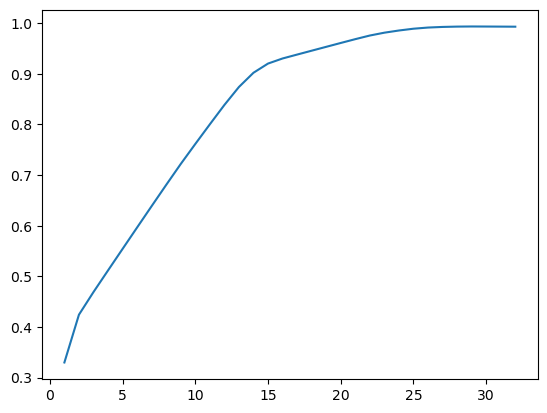

In [181]:
fig,ax=plt.subplots()
ax.plot(range(1,gtn.L//2+1),EE)
# ax.plot(range(1,gtn.L//2),EE[0,-10:,:].T)
# ax.set_xscale('log')
# ax.plot(range(1,gtn.L//2),2*.39*np.log(range(1,gtn.L//2))+.9)

(0.0, 2.0)

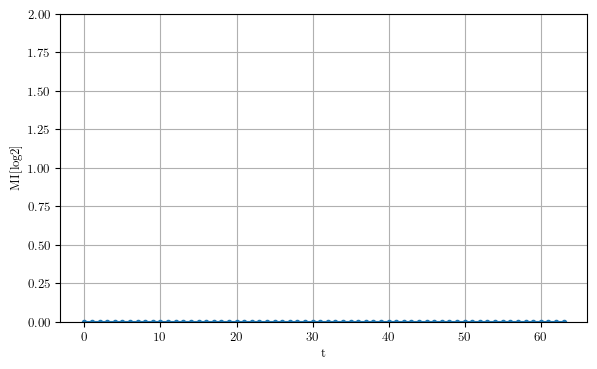

In [36]:
fig,ax=plt.subplots()
ax.plot(MI.mean(axis=0),'.-')
# ax.plot(SL2.mean(axis=0)/np.log(2),'.-')
# plt.plot(EC[-1].sum(axis=1)/np.log(2),'.-')
# ax.plot(iteration,MI.T,'.-')
# ax.plot(iteration,EE[:,:,-1].mean(axis=0))
# ax.plot(iteration,EE_1[:,:,-1].mean(axis=0))
ax.grid('on')
ax.set_xlabel('t')
ax.set_ylabel('MI[log2]')
ax.set_ylim([0,2])
# ax2=ax.twinx()
# ax2.plot(np.array(error[1:]).reshape((iteration.shape[0],-1)).mean(axis=1),'.-',color='r')
# ax2.set_yscale('log')

Text(0, 0.5, 'EE (log2)')

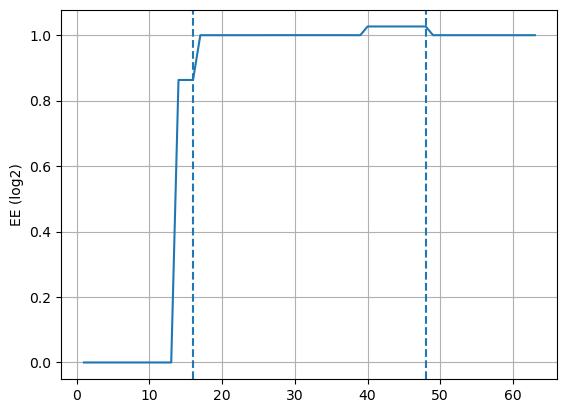

In [67]:
fig,ax=plt.subplots()
ax.plot(range(1,gtn.L),[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L)/np.log(2) for i in range(1)]) for dl in range(1,gtn.L)])
ax.grid('on')
ax.axvline(x=gtn.L//4,ls='dashed')
ax.axvline(x=gtn.L//4*3,ls='dashed')
ax.set_ylabel('EE (log2)')

In [61]:
EC.shape

(1, 9, 128)

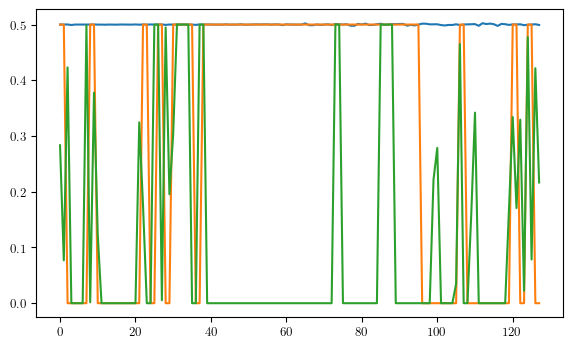

In [68]:
plt.plot(EC.mean(axis=0)[0,:]/np.log(2))

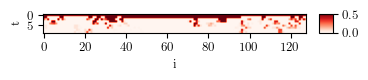

In [65]:
fig,ax=plt.subplots(figsize=(3.4,3.4/1.6))
im=ax.imshow(EC.mean(axis=0)/np.log(2),cmap='Reds')
axins=ax.inset_axes([1.05, 0, 0.05, 1],transform=ax.transAxes)
# ax.imshow(np.array([ec/nla.norm(ec) for ec in EC[0]]),cmap='Reds')
ax.set_ylabel('t')
ax.set_xlabel('i')
plt.colorbar(im,cax=axins,ticks=[0,.5])
# fig.savefig('EC_p_0.8_k_2.pdf')

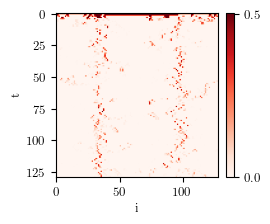

In [ ]:
fig,ax=plt.subplots(figsize=(3.4,3.4/1.6))
im=ax.imshow(EC.mean(axis=0)/np.log(2),cmap='Reds')
axins=ax.inset_axes([1.05, 0, 0.05, 1],transform=ax.transAxes)
# ax.imshow(np.array([ec/nla.norm(ec) for ec in EC[0]]),cmap='Reds')
ax.set_ylabel('t')
ax.set_xlabel('i')
plt.colorbar(im,cax=axins,ticks=[0,.5])
# fig.savefig('EC_p_0.8_k_2.pdf')

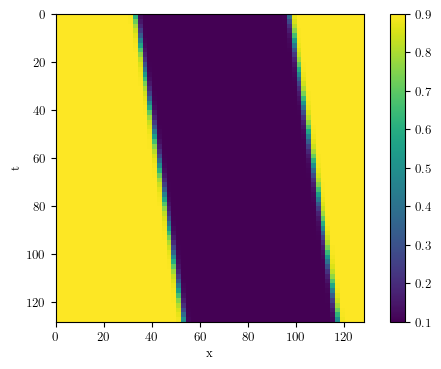

In [80]:
plt.imshow(np.vstack(gtn.p_history[::2]),extent=[0,128,128,0])
plt.ylabel('t')
plt.xlabel('x')
plt.colorbar()

Text(0.5, 0, 'i')

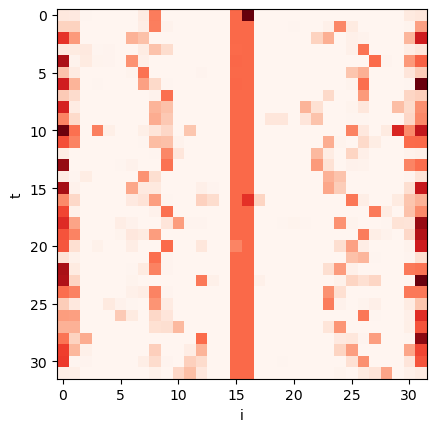

In [316]:
fig,ax=plt.subplots()
ax.imshow(EC[0],cmap='Reds')
# ax.imshow(np.array([ec/nla.norm(ec) for ec in EC[0]]),cmap='Reds')
ax.set_ylabel('t')
ax.set_xlabel('i')

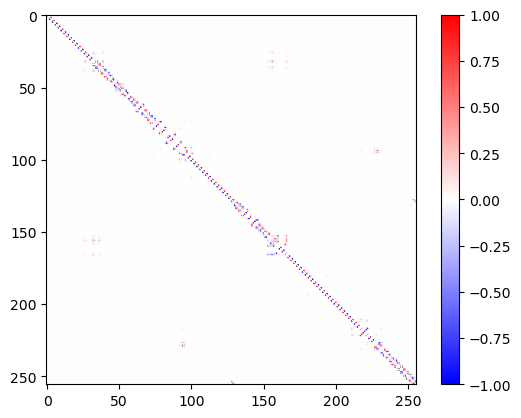

In [56]:
i=-2
fig,ax=plt.subplots()
Gamma=gtn.C_m_history[i+1]
im=ax.imshow(gtn.C_m_history[i+1],cmap='bwr',vmin=-1,vmax=1)
plt.colorbar(im)

# tt=ax.text(0,1.05,'t={:d}: (i,j)=({:d},{:d})   n=({:.2f},{:.2f},{:.2f})   MI={:.2e}   $|\Gamma^2+1|$={:.2e}'.format(i//gtn.L,*gtn.i_history[i],*gtn.n_history[i][0],gtn.MI_history[i],error[i]),transform=ax.transAxes)

In [894]:
def animate(i):
    print(i)
    im.set_array(gtn.C_m_history[i+1])
    tt.set_text('t={:d}: (i,j)=({:d},{:d})   n=({:.2f},{:.2f},{:.2f})   MI={:.2e}   $|\Gamma^2+1|$={:.2e}'.format(i//gtn.L,*gtn.i_history[i],*gtn.n_history[i][0],gtn.MI_history[i],error[i]))

In [ ]:
anim = FuncAnimation(fig, animate, interval=100, frames=len(gtn.i_history))
anim.save('colormap_critical.mp4',dpi=600)

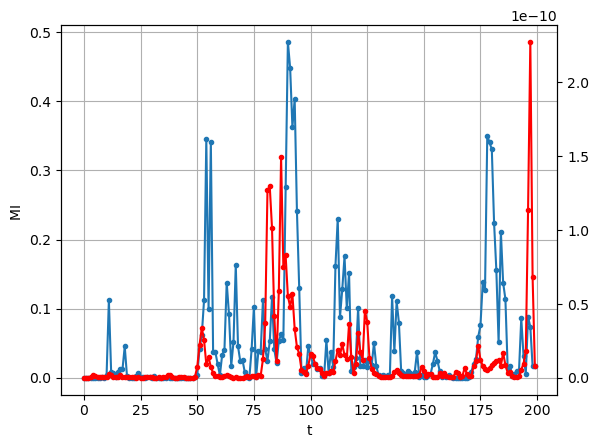

In [ ]:
fig,ax=plt.subplots()
ax.plot(iteration,MI.mean(axis=0),'.-')
# ax.plot(iteration,EE[:,:,-1].mean(axis=0))
# ax.plot(iteration,EE_1[:,:,-1].mean(axis=0))
ax.grid('on')
ax.set_xlabel('t')
ax.set_ylabel('MI ')

ax2=ax.twinx()
ax2.plot(np.array(error[1:]).reshape((iteration.shape[0],-1)).mean(axis=1),'.-',color='r')
# ax2.set_yscale('log')

In [710]:
C_m=gtn.C_m_history[-1]

In [718]:
val,vec=nla.eigh(1j*C_m)

In [723]:
vec_n=vec[:,:C_m.shape[0]//2]

In [725]:
vec_1=np.c_[vec_n,vec_n.conj()]

In [730]:
np.abs(np.imag(vec_1.T.conj()@(1j*C_m)@vec_1)).max()

4.801523335887415e-16

In [750]:
D=np.diag(np.array([-1]*(val.shape[0]//2)+[1]*(val.shape[0]//2)))

In [757]:
C_m_1=(vec@(D)@vec.T.conj()).imag

In [765]:
nla.norm(C_m@C_m+np.eye(C_m.shape[0]))

4.8705571680022986e-12

In [766]:
nla.norm(C_m_1@C_m_1+np.eye(C_m_1.shape[0]))

1.7839684119352026e-14

In [754]:
nla.norm((vec@(D)@vec.T.conj()).imag)

11.313708498984761

In [777]:
def purify(Gamma):
    C_f=1j*Gamma
    val,vec=nla.eigh(C_f)
    D=np.diag(np.array([-1]*(Gamma.shape[0]//2)+[1]*(Gamma.shape[0]//2)))
    return (vec@D@vec.T.conj()).imag

In [783]:
C_m_1=[purify(Gamma) for Gamma in gtn.C_m_history]

In [739]:
np.round(val,0)

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [676]:
np.array(error[1:]).reshape((-1,60))[0].mean()

8.067620645609471e-16

In [685]:
np.array(error[1:]).reshape((60,-1)).mean(axis=1)

array([9.05525654e-16, 8.00748357e-15, 1.20858185e-14, 2.22087973e-13,
       6.41943096e-13, 5.33781352e-13, 1.28338312e-13, 1.84787949e-13,
       8.59737628e-14, 1.12364978e-13, 2.49271090e-13, 1.48847254e-12,
       9.54876803e-13, 2.63482812e-13, 8.45382792e-14, 1.61259894e-13,
       8.27144776e-13, 3.14683175e-13, 2.88541760e-13, 2.54438831e-13,
       2.29725960e-13, 1.53018223e-13, 1.52456173e-13, 6.43686493e-14,
       1.58191168e-13, 7.20673521e-14, 5.42534767e-14, 1.11393533e-13,
       1.89801300e-13, 3.52195703e-13, 2.32166716e-13, 3.63233749e-14,
       5.48788445e-14, 1.24549676e-13, 1.12247017e-13, 2.00259948e-13,
       1.89017205e-13, 7.12285265e-13, 8.76793430e-13, 3.58192642e-13,
       6.68649164e-14, 1.00922742e-13, 1.82106066e-13, 2.24294541e-13,
       1.93463301e-13, 1.00551512e-13, 4.18831636e-14, 8.91387658e-14,
       6.70366540e-14, 4.15834034e-13, 2.21616475e-12, 7.26287433e-12,
       6.98269741e-12, 6.31800341e-12, 2.15213784e-12, 5.46108471e-12,
      

In [670]:
np.array(error[1:61])

array([0.0000000e+00, 4.4408921e-16, 4.4408921e-16, 4.4408921e-16,
       4.4408921e-16, 4.4408921e-16, 4.4408921e-16, 4.4408921e-16,
       4.4408921e-16, 4.4408921e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e-16,
       8.8817842e-16, 8.8817842e-16, 8.8817842e-16, 8.8817842e

In [674]:
np.array(error[61:121])

array([8.88178420e-16, 8.88178420e-16, 8.88178420e-16, 8.88178420e-16,
       8.88178420e-16, 8.88178420e-16, 8.88178420e-16, 8.88178420e-16,
       8.88178420e-16, 8.88178420e-16, 8.88178420e-16, 8.88178420e-16,
       8.88178420e-16, 8.88178420e-16, 8.88178420e-16, 8.88178420e-16,
       9.99200722e-16, 9.99200722e-16, 9.99200722e-16, 1.11022302e-15,
       1.11022302e-15, 1.22124533e-15, 1.22124533e-15, 1.11022302e-15,
       1.11022302e-15, 1.11022302e-15, 1.11022302e-15, 1.11022302e-15,
       9.99200722e-16, 9.99200722e-16, 9.99200722e-16, 9.99200722e-16,
       9.99200722e-16, 9.99200722e-16, 9.99200722e-16, 1.11022302e-15,
       9.99200722e-16, 9.99200722e-16, 9.99200722e-16, 9.99200722e-16,
       9.99200722e-16, 9.99200722e-16, 9.99200722e-16, 9.99200722e-16,
       9.99200722e-16, 9.99200722e-16, 9.99200722e-16, 9.99200722e-16,
       9.99200722e-16, 9.99200722e-16, 9.99200722e-16, 9.99200722e-16,
       9.99200722e-16, 9.99200722e-16, 9.99200722e-16, 9.99200722e-16,
      

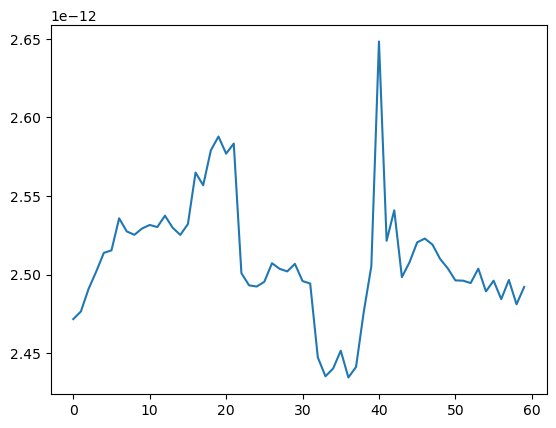

In [662]:
plt.plot(np.array(error[1:]).reshape((-1,60)).mean(axis=0))
# plt.yscale('log')

In [634]:
len(gtn.C_m_history)

3841

In [625]:
np.diag(gtn.C_m_history[-2],k=1)[::2]

array([-0.56229156,  0.50131202, -0.83607698,  0.75358539,  0.42924943,
       -0.31063371,  0.52237775, -0.76579481, -0.70125808,  0.80792034,
        0.91830092,  0.80806345, -0.83593999, -0.50300171, -0.50519311,
        0.93165433,  0.91402502, -0.91713155,  0.40487579,  0.69326397,
       -0.44444661, -0.24931832,  0.65363264, -0.06316381,  0.56911086,
       -0.72971391,  0.94060651,  0.95534366,  0.91007666,  0.84026311,
        0.57546477, -0.1217449 ,  0.12062024,  0.70394342,  0.87284794,
       -0.73976984,  0.60305859,  0.70212572, -0.85955176,  0.60869505,
        0.59927606, -0.81740845,  0.88464099, -0.92666123,  0.88726133,
        0.72899747,  0.47448938, -0.57227205,  0.85724971,  0.81617319,
       -0.84965712, -0.75851393,  0.77078106, -0.71225665, -0.74994287,
        0.35226528, -0.34300025,  0.3277341 ,  0.83823041,  0.80097562,
       -0.03135244,  0.70530906, -0.00926409,  0.90901843])

In [633]:
len(gtn.n_history)/64

60.0

Text(0, 0.5, 'MI ')

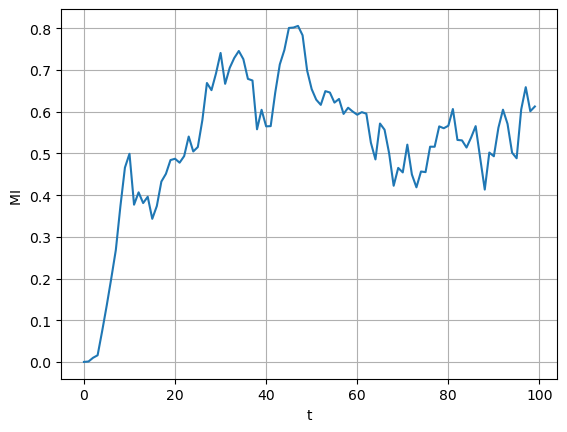

In [345]:
plt.plot(iteration,MI.mean(axis=0))
plt.grid('on')
plt.xlabel('t')
plt.ylabel('MI ')

In [50]:
z=[([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L)/np.log(2) for i in range(gtn.L)]) for dl in range(1,gtn.L//2)]

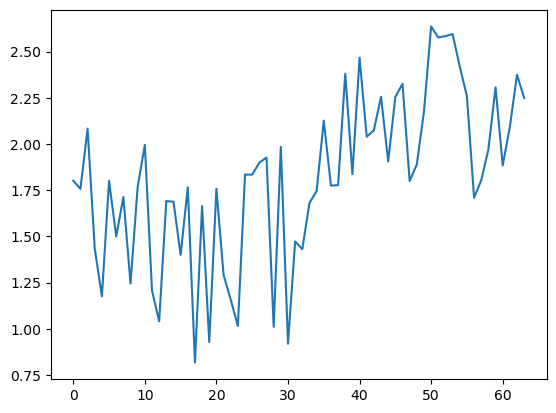

In [51]:
plt.plot(z[10])

In [139]:
gtn.mutual_information_cross_ratio()/np.log(2)

0.3803550405436396

In [141]:
zz=gtn.C_m_history[-1]

In [142]:
np.round(gtn.C_m_history[-1],2)

array([[ 0.  ,  0.54,  0.65, ..., -0.03, -0.24,  0.11],
       [-0.54,  0.  ,  0.41, ...,  0.01,  0.04,  0.22],
       [-0.65, -0.41,  0.  , ...,  0.01,  0.04,  0.25],
       ...,
       [ 0.03, -0.01, -0.01, ...,  0.  ,  0.73,  0.11],
       [ 0.24, -0.04, -0.04, ..., -0.73,  0.  ,  0.62],
       [-0.11, -0.22, -0.25, ..., -0.11, -0.62,  0.  ]])

In [524]:
n2,n3=get_inplane(0, num=10000)

(array([2104.,  872.,  762.,  650.,  625.,  621.,  690.,  750.,  910.,
        2016.]),
 array([-9.99999985e-01, -8.00000051e-01, -6.00000117e-01, -4.00000182e-01,
        -2.00000248e-01, -3.13884356e-07,  1.99999620e-01,  3.99999555e-01,
         5.99999489e-01,  7.99999423e-01,  9.99999357e-01]),
 <BarContainer object of 10 artists>)

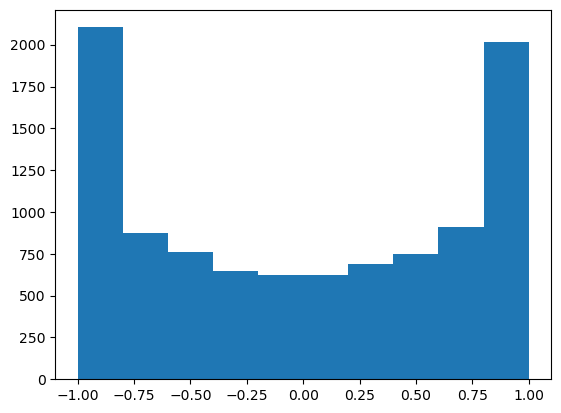

In [525]:
plt.hist(n2)

(array([2064.,  928.,  743.,  703.,  634.,  612.,  667.,  745.,  901.,
        2003.]),
 array([-9.99999863e-01, -7.99999891e-01, -5.99999919e-01, -3.99999947e-01,
        -1.99999975e-01, -2.78171575e-09,  1.99999969e-01,  3.99999941e-01,
         5.99999914e-01,  7.99999886e-01,  9.99999858e-01]),
 <BarContainer object of 10 artists>)

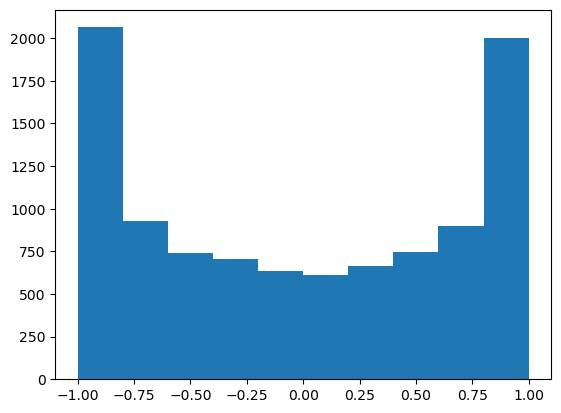

In [519]:
plt.hist(np.sin(np.random.random(size=10000)*np.pi*2))

In [69]:
from scipy import stats

In [70]:
def extract_slope(gtn):
    Cr=[np.mean(np.r_[np.diag(gtn.C_m_history[-1],k=r),np.diag(gtn.C_m_history[-1],k=-(gtn.C_m_history[-1].shape[0]-r))]**2) for r in range(1,gtn.L//2)]
    res=stats.linregress(range(1,gtn.L//2),np.log(Cr))
    return -res.slope
    

In [99]:
# L=128
L_list=[128,]
# iteration=np.arange(128)
ensemble_size=10
sigma_list=np.arange(.1,1.1,.1)
SL2=np.zeros((len(L_list),len(sigma_list),ensemble_size,))
xi_inv=np.zeros((len(L_list),len(sigma_list),ensemble_size,))
for sigma_i,sigma in enumerate(sigma_list):
    print(sigma)
    for L_i,L in enumerate(L_list):
        print(L)
        for ensemble in range(ensemble_size):
            gtn=GTN(L=L,history=True,seed=ensemble,c=[-1,-1,-1])
            for i in range(L):
                gtn.measure_all_Haar(sigma=sigma,even=True,theta_list=0,phi_list=0)
                gtn.measure_all_Haar(sigma=sigma,even=False,theta_list=np.pi/2,phi_list=np.pi/2)
            SL2[L_i,sigma_i,ensemble]=np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+gtn.L//2))%gtn.L) for i in range(gtn.L)])
            xi_inv[L_i,sigma_i,ensemble]=extract_slope(gtn)
            

0.1
128
0.2
128
0.30000000000000004
128
0.4
128
0.5
128
0.6
128
0.7000000000000001
128
0.8
128
0.9
128
1.0
128


(0.0, 1.5)

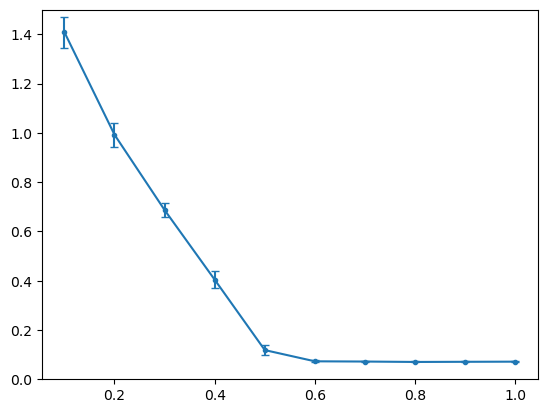

In [100]:
fig,ax=plt.subplots()
ax.errorbar(sigma_list,xi_inv.mean(axis=(2,0)),xi_inv.std(axis=(2,0)),capsize=3,fmt='.-')
ax.set_ylim([0,1.5])

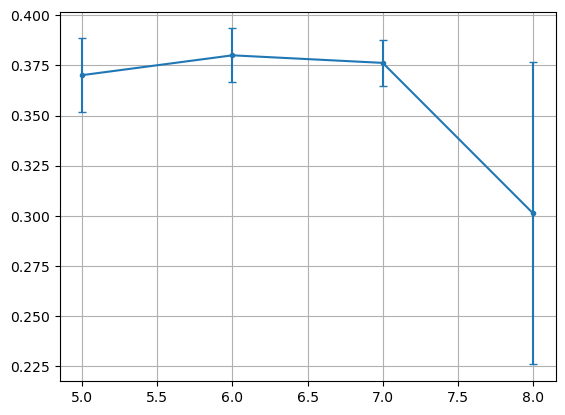

In [604]:
fig,ax=plt.subplots()
ax.errorbar(np.log2(L_list),SL2.mean(axis=1),SL2.std(axis=1)/np.sqrt(SL2.shape[0]),capsize=3,fmt='.-')
ax.grid('on')

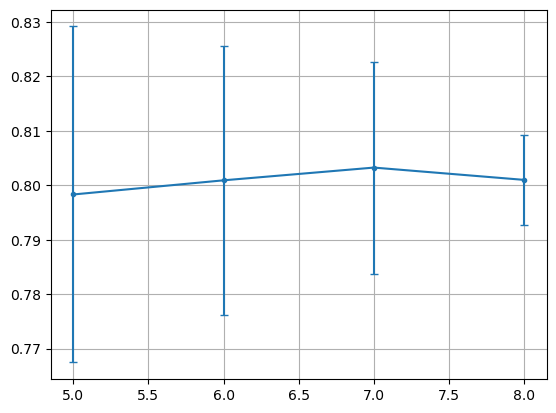

In [ ]:
fig,ax=plt.subplots()
ax.errorbar(np.log2(L_list),SL2.mean(axis=1),SL2.std(axis=1)/np.sqrt(SL2.shape[0]),capsize=3,fmt='.-')
ax.grid('on')

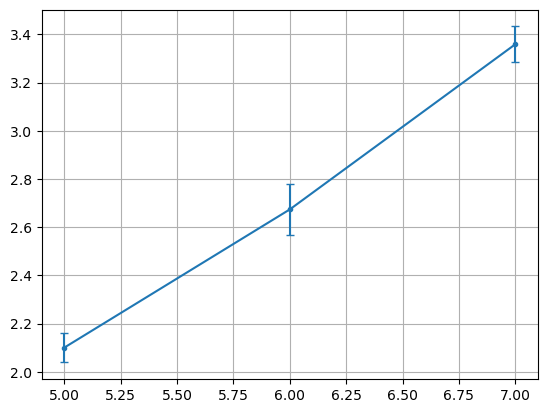

In [ ]:
fig,ax=plt.subplots()
ax.errorbar(np.log2(L_list),SL2.mean(axis=1),SL2.std(axis=1)/np.sqrt(SL2.shape[0]),capsize=3,fmt='.-')
ax.grid('on')

In [590]:
gtn.von_Neumann_entropy_m(np.arange(gtn.L//2))

2.1587535655786243

In [593]:
np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+gtn.L//2))%gtn.L) for i in range(gtn.L)])

0.7946802264146469

In [565]:
# zz=get_random(a1=.5,a2=.5,b1=.5,b2=.5,num=10000)
zz=get_Haar(.25, 10000)

(array([269., 420., 470., 514., 512., 591., 580., 576., 603., 583., 545.,
        546., 557., 578., 504., 555., 494., 478., 383., 242.]),
 array([-0.86568839, -0.77920701, -0.69272563, -0.60624426, -0.51976288,
        -0.4332815 , -0.34680012, -0.26031874, -0.17383737, -0.08735599,
        -0.00087461,  0.08560677,  0.17208815,  0.25856952,  0.3450509 ,
         0.43153228,  0.51801366,  0.60449503,  0.69097641,  0.77745779,
         0.86393917]),
 <BarContainer object of 20 artists>)

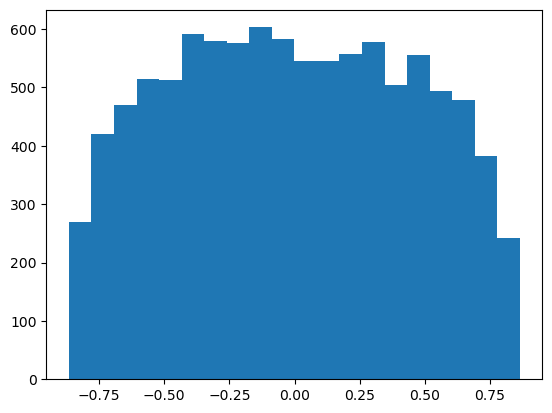

In [568]:
plt.hist(zz[:,2],bins=20)
# plt.hist(n3,bins=20)

In [508]:
np.sqrt(1-0.9**2)

0.4358898943540673

In [22]:
x=np.random.uniform(size=1000)

In [23]:
y=np.sqrt(x)

(array([ 29.,  38.,  45.,  77.,  92., 109., 131., 145., 171., 163.]),
 array([0.04806721, 0.14314844, 0.23822967, 0.3333109 , 0.42839213,
        0.52347336, 0.61855459, 0.71363582, 0.80871705, 0.90379828,
        0.99887951]),
 <BarContainer object of 10 artists>)

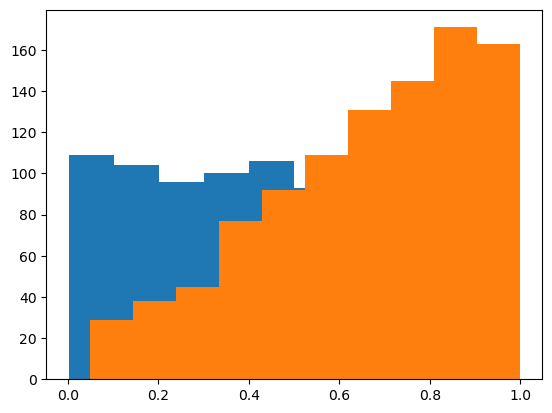

In [28]:
plt.hist(x)
plt.hist(y)

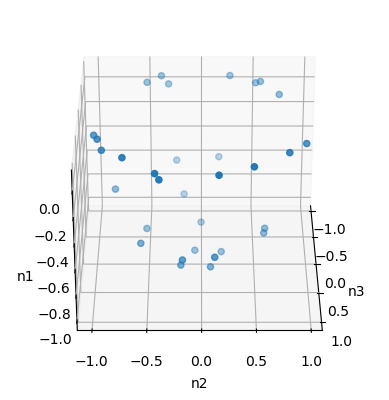

In [107]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
zz=np.array(gtn.n_history[:32])
ax.scatter(zz[:,2],zz[:,1],zz[:,0])
ax.set_xlabel('n3')
ax.set_ylabel('n2')
ax.set_zlabel('n1')
ax.view_init(azim=0)

In [309]:
gtn=GTN(L=128)
for r in range(10):
    for i in range(0,gtn.L,2):
        gtn.measure([1,0,0], [i,(i+1)%(2*gtn.L)])
    for i in range(1,gtn.L,2):
        gtn.measure([0,0,1], [i,(i+1)%(2*gtn.L)])
# gtn.measure_all_forced(b2=1,a2= 1, a1= 1,b1= 1,even=True,n1_z=True)
# mat1,mat2,mat3=gtn.measure(np.array([0,1,0]), [0,1])
# mat1,mat2,mat3=gtn.measure(np.array([-.99999,np.sqrt(1-.99999**2),0]), [0,1])

In [310]:
gtn.mutual_information_cross_ratio()

0.0

In [ ]:
gtn.n_history

In [271]:
mat1

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [272]:
mat2

array([[ 0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [273]:
mat3

array([[ 0.,  1.,  1.,  0.],
       [-1.,  0.,  0.,  1.],
       [-1., -0.,  0.,  0.],
       [-0., -1.,  0.,  0.]])

In [274]:
pd.DataFrame(np.linalg.inv(mat3))

,0,1,2,3
0,-0.0,-0.0,-1.0,-0.0
1,0.0,0.0,0.0,-1.0
2,1.0,0.0,0.0,1.0
3,-0.0,1.0,-1.0,-0.0


In [275]:
gtn.n_history

[array([0, 1, 0])]

In [276]:
gtn.C_m_history

[array([[ 0.,  1.,  0.,  0.],
        [-1.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-0.,  0., -1.,  0.]]),
 array([[ 0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.]])]

In [296]:
L_list=2**np.arange(4,8)
iteration=np.arange(200)
MI=np.zeros((L_list.shape[0],iteration.shape[0]))
for L_i,L in enumerate(L_list):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=0.1,a2= 0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=0.1,a2= 0, a1=.5,b1= 1,even=False,n1_z=False)
        MI[L_i,i]=gtn.mutual_information_cross_ratio()

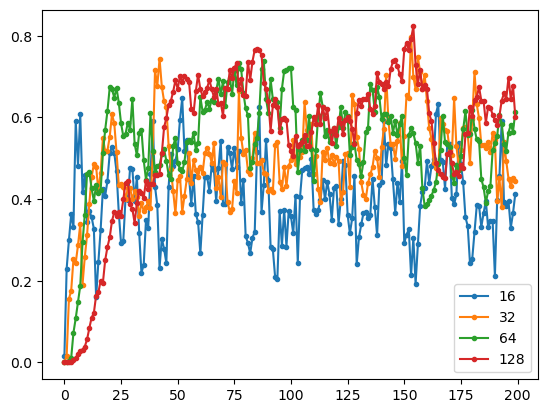

In [298]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

In [299]:
L_list=2**np.arange(4,8)
iteration=np.arange(200)
MI_critical=np.zeros((L_list.shape[0],iteration.shape[0]))
for L_i,L in enumerate(L_list):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=1,a2= 0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=1,a2= 0, a1=.5,b1= 1,even=False,n1_z=False)
        MI_critical[L_i,i]=gtn.mutual_information_cross_ratio()

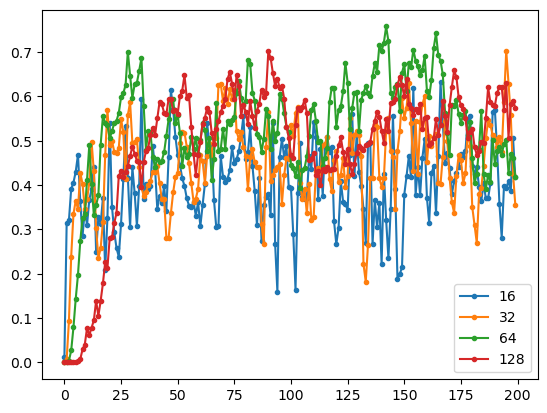

In [300]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI_critical[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI_critical[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

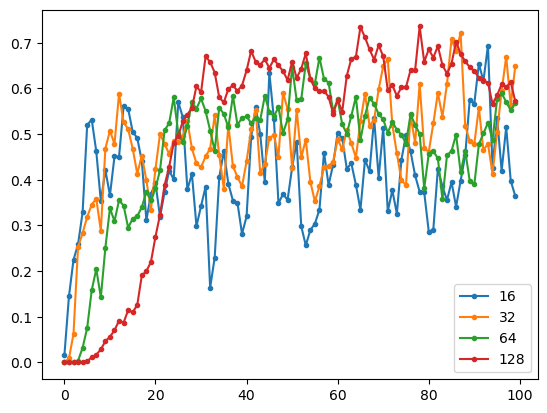

In [192]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI_critical[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI_critical[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

In [255]:
gtn.measure(np.array([1,0,0]), [0,1])

In [257]:
gtn.measure(np.array([1,1,0]), [0,1])

In [285]:
# gtn.measure_all_forced(b2=-.9,a2= -.7, a1=.7,b1= .9)
gtn.measure_all_forced(b2=-.9,a2= -.7, a1=.7,b1= .9,even=False)

In [283]:
gtn.n_history

[array([ 0.70708212, -0.6158029 ,  0.34759411]),
 array([ 0.71292935, -0.07927067,  0.69674092]),
 array([-0.73656885,  0.6753321 ,  0.03732137]),
 array([-0.87550474, -0.06941651, -0.47819745])]

In [209]:
np.round(gtn.kraus(gtn.n_history[0]))

array([[-0.,  1., -0., -0.],
       [-1., -0.,  0., -0.],
       [ 0., -0., -0., -1.],
       [ 0.,  0.,  1., -0.]])

In [288]:
gtn.mutual_information_m([0,1],[2,3])/np.log(2)

2.718401573307823

In [ ]:
gtn.C_m_history

In [287]:
np.round(gtn.C_m_history[-1]@gtn.C_m_history[-1]+np.eye(gtn.C_m_history[-1].shape[0]),4)

array([[ 0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0.,  0.],
       [-0.,  0.,  0.,  0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0., -0., -0.,  0., -0.,  0.],
       [ 0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [-0., -0.,  0., -0., -0.,  0.,  0.,  0.]])

In [154]:
zz=gtn.get_random(b2=-.8,a2= -.2, a1=.6,b1= .8,n= 100)

In [ ]:
zz

In [156]:
np.linalg.norm(zz,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

(array([646., 675., 635., 655., 646., 684., 672., 722., 665., 636., 689.,
        162.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 511., 678., 641., 683.]),
 array([-7.99993005e-01, -7.46663848e-01, -6.93334691e-01, -6.40005535e-01,
        -5.86676378e-01, -5.33347221e-01, -4.80018065e-01, -4.26688908e-01,
        -3.73359751e-01, -3.20030595e-01, -2.66701438e-01, -2.13372281e-01,
        -1.60043125e-01, -1.06713968e-01, -5.33848111e-02, -5.56544542e-05,
         5.32735022e-02,  1.06602659e-01,  1.59931816e-01,  2.13260972e-01,
         2.66590129e-01,  3.19919286e-01,  3.73248442e-01,  4.26577599e-01,
         4.79906756e-01,  5.33235912e-01,  5.86565069e-01,  6.39894226e-01,
         6.93223383e-01,  7.46552539e-01,  7.99881696e-01]),
 <BarContainer object of 30 artists>)

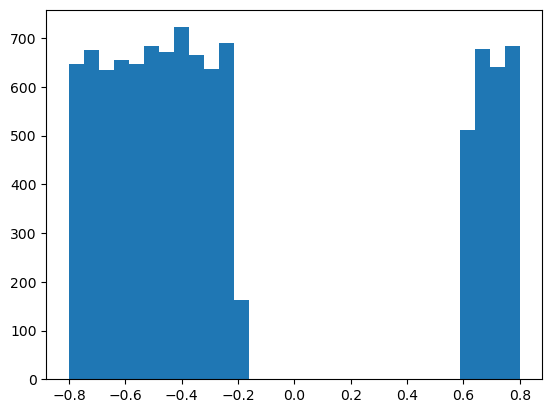

In [124]:
plt.hist(zz,30)

In [97]:
gtn.kraus(np.array([1,0,0]),theta=0)

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0., -0.,  0.],
       [-0.,  0.,  0., -1.],
       [-0., -0.,  1.,  0.]])

In [77]:
gtn.C_m

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0., -0.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [-0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [67]:
gtn.C_m=np.array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [72]:
gtn.C_m_history=[np.array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])]

In [56]:
gtn.measure(0, [0,1])

In [57]:
gtn.i_history

[[0, 1], [0, 1]]

In [73]:
gtn.C_m_history

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])]

In [25]:
gtn.measure(0, [0,1])

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [19]:
gtn.measure(1, [1,2])

array([[ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [60]:
gtn.von_Neumann_entropy_m([0,1])

In [75]:
gtn.mutual_information_m([0,1],[2,3])/np.log(2)

2.0

# Draft

In [ ]:
L=64
gtn=GTN(L=L,seed=0+1,history=True,op=False,trijunction=True,random_init=False)

In [ ]:
site_lists=[]
p_lists=[]
_=initialization(gtn.L,p=1,time=4,site_lists=site_lists,p_lists=p_lists)

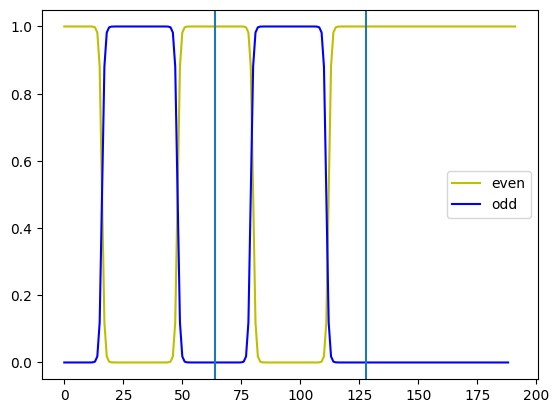

In [ ]:
plt.plot(p_lists[0],label='even',color='y')
plt.plot(p_lists[1],label='odd',color='b')
plt.axvline(x=64)
plt.axvline(x=128)
plt.legend()

In [ ]:
# len(braiding.site_lists)
len(braiding.p_lists)

35

In [ ]:
np.array(braiding.site_lists[2*15])

array([[127, 255]])